# Estratificação de Risco usando Registros Eletrônicos de Pacientes Diabéticos

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.11


## Definição do Problema

As readmissões hospitalares são caras e refletem as inadequações no sistema de saúde. Nos Estados Unidos sozinho, o tratamento de pacientes diabéticos readmitidos excede 300 milhões de dólares por ano. Identificação precoce de pacientes que enfrentam um alto risco de readmissão pode permitir que os profissionais de saúde conduzam investigações adicionais e possivelmente impeçam futuras readmissões. Isso não apenas melhora a qualidade do atendimento, mas também reduz as despesas médicas em readmissão. 

Diabetes é a <a href="https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death">sétima principal causa de morte (dados de 2016)</a> no mundo e afeta cerca de 23,6 milhões de pessoas só nos EUA e milhões de pessoas são diagnosticados com diabetes a cada ano em todo mundo. 

Segundo a <a href="https://www.diabetes.org/">Associação Americana de Diabetes</a>, o custo do atendimento a pacientes diabéticos e pré-diabéticos nos Estados Unidos é o maiior do mundo. Essa epidemia global afeta mais de 350 milhões de pessoas, com 3 milhões de pessoas morrendo a cada ano devido a complicações relacionadas ao diabetes, predominantemente cardiovasculares ou nefropáticas.

A readmissão hospitalar é uma das principais preocupações no tratamento do diabetes, com milhões de dólares sendo gastos no tratamento de pacientes diabéticos que precisam ser readmitidos em um hospital após receberem alta. 

A necessidade de readmissão indica que cuidados inadequados foram fornecidos ao paciente no momento da primeira admissão. A taxa de readmissão se tornou uma métrica importante para medir a qualidade geral de um hospital.

Neste projeto usaremos registros eletrônicos de dados médicos, como resultados dos exames, nível de insulina, diagnóstico de outras doenças, etc...

Mas não vamos "apenas" prever se um paciente pode ou não ser readmitido. Vamos estratificar o risco em 3 categorias e realizar uma análise completa das métricas fornecidas pelos modelos.

Vamos treinar e comparar o desempenho de alguns algoritmos de aprendizado de máquina e decidir qual deles usar para prever o risco de readmissão para o paciente.

Usaremos o melhor modelo treinado para estratificar a população em três grupos de risco:

- **Alto Risco** (probabilidade de readmissão > 0,7)
- **Risco Médio** (0,3 < Probabilidade de readmissão < 0,7)
- **Baixo Risco** (probabilidade de readmissão < 0,3)

Observe que maior sensibilidade (recall) é mais desejável para os hospitais porque é mais importante identificar corretamente pacientes de "alto risco" que provavelmente serão readmitidos do que identificar pacientes de "baixo risco".

Vamos justificar todas as nossas escolhas durante o desenvolvimento do projeto.

Os EUA mantém um programa constante de redução de readmissão de pacientes:

<a href="https://www.cms.gov/Medicare/Quality-Initiatives-Patient-Assessment-Instruments/Value-Based-Programs/HRRP/Hospital-Readmission-Reduction-Program">Hospital Readmissions Reduction Program (HRRP)</a>

# 0.0 Carregando os Dados e Compreendendo as Variáveis

In [2]:
# Imports
import keras
import numpy             as np
import pandas            as pd
import seaborn           as sns
import sklearn
import matplotlib        as m
import tensorflow
import matplotlib
import statsmodels
import matplotlib.pyplot as plt

from keras.models                         import Sequential
from keras.layers                         import Dense
from keras.layers                         import Dropout
from sklearn.tree                         import DecisionTreeClassifier
from sklearn.metrics                      import roc_auc_score
from sklearn.metrics                      import r2_score
from sklearn.metrics                      import roc_curve
from sklearn.metrics                      import classification_report
from sklearn.metrics                      import accuracy_score
from sklearn.metrics                      import confusion_matrix
from sklearn.metrics                      import recall_score
from sklearn.metrics                      import precision_score
from sklearn.metrics                      import auc
from sklearn.ensemble                     import AdaBoostClassifier
from sklearn.ensemble                     import RandomForestClassifier
from sklearn.ensemble                     import GradientBoostingClassifier
from sklearn.linear_model                 import Lasso
from sklearn.linear_model                 import SGDClassifier
from sklearn.linear_model                 import LogisticRegression
from sklearn.preprocessing                import StandardScaler
from sklearn.model_selection              import cross_val_score
from sklearn.model_selection              import ShuffleSplit
from sklearn.model_selection              import GridSearchCV
from sklearn.model_selection              import learning_curve
from sklearn.model_selection              import train_test_split,cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [230]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Risk Stratification" --iversions

Author: Risk Stratification

re         : 2.2.1
pandas     : 1.3.2
sklearn    : 0.24.2
seaborn    : 0.11.2
statsmodels: 0.12.2
imblearn   : 0.0
tensorflow : 2.6.0
keras      : 2.6.0
matplotlib : 3.4.2
numpy      : 1.19.5



## Dataset

O conjunto de dados, "Diabetes 130-US hospitals for years 1999-2008", foi baixado do UCI Machine Learning Repository. 

Os dados representam 10 anos (1999-2008) de atendimento clínico em 130 hospitais dos EUA e redes de distribuição integradas com 100.000 observações e 50 recursos (variáveis) que representam os registros eletrônicos com resultados de exames dos pacientes e dados sobre cada hospital.

<a href="http://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008">Diabetes 130-US hospitals for years 1999-2008 Data Set</a>

A coleta dos dados foi descrita pelos autores neste trabalho:

> O controle da hiperglicemia em pacientes hospitalizados tem uma influência significativa no resultado, tanto em termos de morbidade quanto de mortalidade. No entanto, existem poucas avaliações nacionais sobre o tratamento do diabetes durante a hospitalização que podem servir de base para a mudança. 

> Essa análise de um grande banco de dados clínicos (74 milhões de encontros únicos correspondentes a 17 milhões de pacientes únicos) foi realizada para fornecer essa avaliação e encontrar orientações futuras que possam levar a melhorias na segurança do paciente. Quase 70.000 encontros de pacientes internados com diabetes foram identificados com detalhes suficientes para análise. A regressão logística multivariável foi usada para ajustar a relação entre a medida da HbA1c e a readmissão precoce, enquanto o controle de covariáveis, como dados demográficos, gravidade e tipo da doença, e tipo de admissão. 

> Os resultados mostram que a medição da HbA1c foi realizada com pouca frequência (18,4%) no ambiente hospitalar. O modelo estatístico sugere que a relação entre a probabilidade de readmissão e a medição da HbA1c depende do diagnóstico primário. Os dados sugerem ainda que a maior atenção ao diabetes refletida na determinação da HbA1c pode melhorar os resultados dos pacientes e reduzir o custo dos cuidados hospitalares.

HbA1c é uma medida de quão bem o seu açúcar no sangue está controlado durante um período de cerca de 3 meses. Essencialmente, dá uma boa ideia de quão altos ou baixos, em média, foram os níveis de glicose no sangue.

Descrição completa do trabalho:

<a href="https://www.hindawi.com/journals/bmri/2014/781670/">Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records</a>


In [4]:
# Carregando os dados
dados = pd.read_csv("dados/diabetic_data.csv")

In [5]:
# Visualizando os dados
dados.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# Shape
dados.shape

(101766, 50)

In [7]:
# Info
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Dicionário de Dados:
    
- 0- **encounter_id** - identificador único de um encontro do pesquisador com o paciente.
- 1- **patient_nbr** - identificador exclusivo de um paciente.
- 2- **race** - valores: Caucasian, Asian, African American, Hispanic e other.
- 3- **gender** - valores: male, female, and unknown/invalid.
- 4- **age** - agrupados em intervalos de 10 anos: (0, 10), (10, 20), ..., (90, 100).
- 5- **weight** - peso em libras.
- 6- **admission_type_id** - identificador inteiro correspondente a 9 valores distintos, por exemplo, "emergência, urgência, eletiva, recém-nascido e não disponível".
- 7- **discharge_disposition_id** - identificador inteiro correspondente a 29 valores distintos, por exemplo, "enviado para casa, expirou e não está disponível".
- 8- **admission_source_id** - identificador inteiro correspondente a 21 valores distintos, por exemplo, "encaminhamento médico, e transferência de um hospital".
- 9- **time_in_hospital** - número inteiro de dias entre a admissão e a alta,
- 10- **payer_code** - identificador inteiro correspondente a 23 valores distintos, por exemplo, Blue Cross / Blue Shield, Medicare e auto-pagamento".
- 11- **medical_specialty** - identificador inteiro de uma especialidade do médico admitidor, correspondente a 84 valores distintos, por exemplo, cardiologia, medicina interna, família / clínica geral e cirurgião".
- 12- **num_lab_procedures** - número de testes de laboratório realizados durante a consulta.
- 13- **num_procedures** - número de procedimentos (exceto testes de laboratório) realizados durante a consulta.
- 14- **num_medications** - número de medicamentos genéricos distintos administrados durante a consulta.
- 15- **number_outpatient** - número de consultas ambulatoriais do paciente no ano anterior a consulta.
- 16- **number_emergency** - número de visitas de emergência do paciente no ano anterior a consulta.
- 17- **number_inpatient** - número de visitas hospitalares do paciente no ano anterior a consulta.
- 18- **diag_1** - diagnóstico primário (codificado como três primeiros dígitos da CID9); 848 valores distintos.
- 19- **diag_2** - diagnóstico secundário (codificado como três primeiros dígitos da CID9); 923 valores distintos.
- 20- **diag_3** - diagnóstico secundário adicional (codificado como três primeiros dígitos da CID9); 954 valores distintos.
- 21- **number_diagnoses** - número de diagnósticos inseridos no sistema.
- 22- **max_glu_serum** - teste sérico de glicose que indica a faixa do resultado ou se o teste não foi realizado. Valores: > 200, > 300, normal e nenhum, se não for medido.
- 23- **A1Cresult** - teste A1c que indica o intervalo do resultado ou se o teste não foi realizado. Valores: > 8 (se o resultado for maior que 8%), > 7 (se o resultado for maior que 7%, porém menor que 8%), normal (se o resultado for inferior a 7%) e nenhum, se não for medido.

Na sequência temos os recursos de 24 a 46 para os nomes dos medicamentos genéricos:

metformina, repaglinida, nateglinida, clorpropamida, glimepirida, acetohexamida, glipizida, gliburida, tolbutamida, pioglitazona, rosiglitazona, acarbose, miglitol, troglitazona, insulazforamida, examide, sitaglagliptida, sitazagliptida , glipizida-metformina, glimepirida-pioglitazona, metformina-rosiglitazona e metformina-pioglitazona, 

Cada um desses recursos indica se o medicamento foi prescrito ou se houve uma alteração na dosagem. Valores: "up" se a dose foi aumentada durante a consulta. 

- 47- **change** - indica se houve alteração nos medicamentos para diabéticos (dosagem ou nome genérico). Valores: "change" e "no change".
- 48- **diabetesMed** - indica se houve algum medicamento diabético prescrito. Valores: "sim" e "não".
- 49- **readmitted** - readmitido, "Dias para readmissão hospitalar. Valores: <30 (se o paciente foi readmitido em menos de 30 dias), > 30 (se o paciente foi readmitido em mais de 30 dias) e No, para nenhum registro de readmissão. 

Nota: Códigos ICD-9 ou CID-9 (International Classification of Diseases ou Código Internacional de Doenças).

# 1.0 Limpeza e Transformação dos Dados

In [8]:
# Verificando valores nulos
dados.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [9]:
# Verificando valores únicos
for col in list(dados.columns):
    
    # Obtém uma lista de valores únicos
    list_of_unique_values = dados[col].unique()
    
    # Se o número de valores exclusivos for menor que 15, imprima os valores. 
    # Caso contrário, imprima o número de valores exclusivos
    if len(list_of_unique_values) < 15:
        print("\n")
        print(col + ': ' + str(len(list_of_unique_values)) + ' valores únicos')
        print(list_of_unique_values)
    else:
        print("\n")
        print(col + ': ' + str(len(list_of_unique_values)) + ' valores únicos')



encounter_id: 101766 valores únicos


patient_nbr: 71518 valores únicos


race: 6 valores únicos
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']


gender: 3 valores únicos
['Female' 'Male' 'Unknown/Invalid']


age: 10 valores únicos
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']


weight: 10 valores únicos
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']


admission_type_id: 8 valores únicos
[6 1 2 3 4 5 8 7]


discharge_disposition_id: 26 valores únicos


admission_source_id: 17 valores únicos


time_in_hospital: 14 valores únicos
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]


payer_code: 18 valores únicos


medical_specialty: 73 valores únicos


num_lab_procedures: 118 valores únicos


num_procedures: 7 valores únicos
[0 5 1 6 2 3 4]


num_medications: 75 valores únicos


number_outpatient: 39 valores únicos


number_emergency: 33 valores únicos


number_inpati

In [10]:
# Checando as colunas que tem valor = '?'
dados.isin(['?']).any()

encounter_id                False
patient_nbr                 False
race                         True
gender                      False
age                         False
weight                       True
admission_type_id           False
discharge_disposition_id    False
admission_source_id         False
time_in_hospital            False
payer_code                   True
medical_specialty            True
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_inpatient            False
diag_1                       True
diag_2                       True
diag_3                       True
number_diagnoses            False
max_glu_serum               False
A1Cresult                   False
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide 

**O caracter '?' nada mais é do que valor ausente. Vamos limpar isso.**

In [11]:
# Vamos verificar a quantidade e percentual de registros onde o valor é igual a '?'
for col in dados.columns:
    if dados[col].dtype == object:
        if dados[col][dados[col] == '?'].count() > 0:
            print('\nColuna', col, 'tem', dados[col][dados[col] == '?'].count(), 'valores com o caracter "?"')
            print('Isso representa', round(dados[col][dados[col] == '?'].count() / len(dados.index) * 100, 2), '% do total')



Coluna race tem 2273 valores com o caracter "?"
Isso representa 2.23 % do total

Coluna weight tem 98569 valores com o caracter "?"
Isso representa 96.86 % do total

Coluna payer_code tem 40256 valores com o caracter "?"
Isso representa 39.56 % do total

Coluna medical_specialty tem 49949 valores com o caracter "?"
Isso representa 49.08 % do total

Coluna diag_1 tem 21 valores com o caracter "?"
Isso representa 0.02 % do total

Coluna diag_2 tem 358 valores com o caracter "?"
Isso representa 0.35 % do total

Coluna diag_3 tem 1423 valores com o caracter "?"
Isso representa 1.4 % do total


In [12]:
# A coluna gender apresenta um valor que precisamos tratar
print('\nColuna gender tem', dados['gender'][dados['gender'] == 'Unknown/Invalid'].count(), 'valores com "Unknown/Invalid"')
print('Isso representa', round(dados['gender'][dados['gender'] == 'Unknown/Invalid'].count() / len(dados.index) * 100, 2), '% do total')


Coluna gender tem 3 valores com "Unknown/Invalid"
Isso representa 0.0 % do total


**Agora a parte importante - decidir o que fazer!**

- Falta os dados sobre peso do paciente em mais de 96% dos registros. 

- O código do pagador e a Especialidade Médica também apresentam valores ausentes de 40 a 50%. 

- As demais variáveis apresentam um baixo percentual de valores ausentes.

O que fazer?

**Decisão:**

- 1- Devido à fraca interpretabilidade dos valores ausentes da variável peso e à pouca generalização preditiva para outros pacientes, o melhor é simplesmente ignorar a variável e removê-la.

- 2- Vamos descartar as variáveis payer_code e medical_specialty, pois seria difícil tratar quantidade muito grande de valores ausentes.

**Alternativas:**

- Colocar a variável peso como categórica com dois labels: disponível / não disponível (1 e 0).
- Criar um código genérico para a variável payer_code como 99 e preencher os valores ausentes.
- Criar um tipo genérico para a variável medical_specialty como 'Sem Especialidade Definida' e preencher os valores ausentes.

In [13]:
# Removendo as 3 colunas com alto percentual de valores ausentes
dados = dados.drop(['weight','payer_code','medical_specialty'], axis = 1)

Para as demais variáveis com baixo percentual de valores ausentes, removemos os registros.

In [14]:
# Removemos os registros com baixo percentual de valores ausentes
dados = dados[dados['race'] != '?']
dados = dados[dados['diag_1'] != '?']
dados = dados[dados['diag_2'] != '?']
dados = dados[dados['diag_3'] != '?']
dados = dados[dados['gender'] != 'Unknown/Invalid']

In [15]:
# Checando as colunas que tem valor = '?'
dados.isin(['?']).any()

encounter_id                False
patient_nbr                 False
race                        False
gender                      False
age                         False
admission_type_id           False
discharge_disposition_id    False
admission_source_id         False
time_in_hospital            False
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_inpatient            False
diag_1                      False
diag_2                      False
diag_3                      False
number_diagnoses            False
max_glu_serum               False
A1Cresult                   False
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide               False
glipizide                   False
glyburide                   False
tolbutamide   

In [16]:
# Shape
dados.shape

(98052, 47)

**Será que temos variáveis com um único valor?**

In [17]:
# Visualiza os dados
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [18]:
# Checando por variáveis com um único valor
dados.loc[:, dados.nunique() == 1]

,examide,citoglipton,metformin-rosiglitazone
1,No,No,No
2,No,No,No
3,No,No,No
4,No,No,No
5,No,No,No
...,...,...,...
101761,No,No,No
101762,No,No,No
101763,No,No,No
101764,No,No,No


**Vamos eliminar as colunas que têm apenas 1 valor único, pois elas não adicionam nada à nossa análise.**

In [19]:
# Removendoo variáveis com valores únicos
dados = dados.loc[:, dados.nunique() != 1]

In [20]:
# Shape
dados.shape

(98052, 44)

## Engenharia de Atributos

### Ajustando a Variável Alvo Para Estratificação de Risco

Uma readmissão hospitalar ocorre quando um paciente que recebe alta do hospital é readmitido novamente dentro de um certo período de tempo. As taxas de readmissão hospitalar para certas condições agora são consideradas um indicador da qualidade do hospital e também afetam negativamente o custo médico. 

Nossa variável alvo é 'readmiited'. Queremos saber se um paciente será readmitido no hospital ou não.

A variável possui os valores:

-- < 30 (readmissão em menos de 30 dias)

-- > 30 (readmissão em mais de 30 dias)

-- No   (sem readmissão)

Nós podemos combinar a readmissão antes de 30 dias e após 30 dias em uma categoria (valor 1 - classe positiva) e nenhuma readmissão em outra categoria (valor 0 - classe negativa) para tornar nosso problema classificação binária.

In [21]:
# Primeiro, vamos criar uma cópia do dataset
dados_clean1 = dados

In [22]:
# Ajustando a variável alvo

# '0' significa que não foi readmitido
# '1' significa que foi readmitido, não importa quantos dias após a alta

dados['readmitted'] = dados['readmitted'].replace('>30', 1)
dados['readmitted'] = dados['readmitted'].replace('<30', 1)
dados['readmitted'] = dados['readmitted'].replace('NO', 0)

In [23]:
# Verifica os valores únicos
dados['readmitted'].unique()

array([1, 0], dtype=int64)

In [24]:
# Checa o tipo de dado
dados['readmitted'].dtype

dtype('int64')

In [25]:
# Verifica a proporção de cada classe
round(dados.readmitted.value_counts() / len(dados.index) * 100, 0)

0    53.0
1    47.0
Name: readmitted, dtype: float64

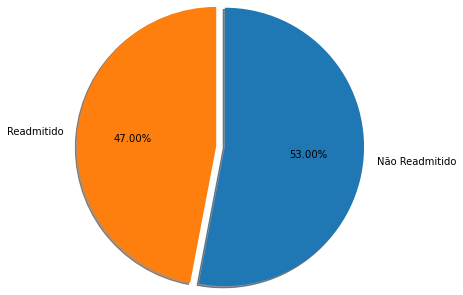

In [26]:
# Vamos visualizar de forma gráfica

# Percentual de cada valor da variável alvo
percentual = round(dados.readmitted.value_counts() / len(dados.index) * 100, 0)

# Labels
labels = ['Não Readmitido', 'Readmitido']

# Plot
plt.axis("equal")
plt.pie(percentual , 
        labels = labels,
        radius = 1.6,
        autopct = '%1.2f%%',
        explode = [0.05,0.05],
        startangle = 90,
        shadow = True,
        counterclock = False,
        pctdistance = 0.6)
plt.show()

> Cerca de 47% dos pacientes de diabetes foram readmitidos nos hospitais.

## Recategorização de Variável

Como tratamos a variável idade?

In [27]:
# Tipo da variável
dados.age.dtype

dtype('O')

In [28]:
# Total de pacientes por faixa etária
dados.groupby('age').size()

age
[0-10)         65
[10-20)       466
[20-30)      1478
[30-40)      3548
[40-50)      9265
[50-60)     16697
[60-70)     21809
[70-80)     25305
[80-90)     16702
[90-100)     2717
dtype: int64

Text(0, 0.5, 'Count')

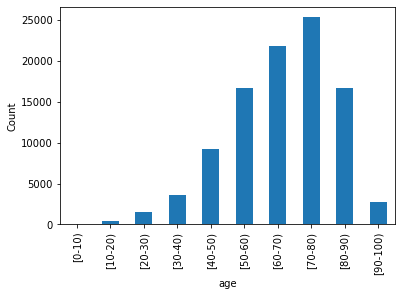

In [29]:
# Vamos verificar a variável que representa a faixa etária dos pacientes
dados.groupby('age').size().plot(kind = 'bar')
plt.ylabel('Count')

> Podemos perceber que a maioria dos pacientes está na faixa entre 50 e 90 anos. 

Existem diferentes maneiras de lidar com essa variável. O conjunto de dados nos dá a idade apenas como categorias nas faixas de 10 anos, portanto, não sabemos a idade exata de cada paciente. 

Podemos adotar duas abordagens:

- 1- Se queremos ver o efeito do aumento da idade na readmissão do paciente, mesmo que de maneira grosseira, podemos assumir que a idade do paciente, em média, esteja no ponto médio da categoria de idade. Por exemplo, se a categoria de idade do paciente é de 20 a 30 anos, assumimos a idade = 25 anos. Então, convertemos categorias de idade em pontos médios, resultando em uma variável numérica.


- 2- Podemos recategorizar a variável, distribuindo os pacientes por um número menor de faixas e manter a variável como categórica. Nesse caso, poderíamos avaliar o risco por faixa etária e não por idade.

**Adotaremos a opção 2**

In [30]:
# Recategorizamos 'idade' para que a população seja distribuída de maneira mais uniforme

# Classificamos como faixa de 0-50 pacientes de até 50 anos
dados['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                          for val in dados['age']], index = dados.index)

# Acima de 80 anos ficam na faixa de 80-100
dados['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                          for val in dados['age']], index = dados.index)

# As outras faixas são mantidas

In [31]:
# Tipo ds variável
dados.age.dtype

dtype('O')

Text(0, 0.5, 'Count')

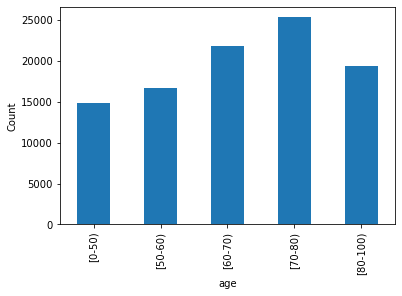

In [32]:
# Vamos verificar a variável que representa a faixa etária dos pacientes
dados.groupby('age').size().plot(kind = 'bar')
plt.ylabel('Count')

**Como tratamos variáveis ID de tipo?**

Uma análise mais detalhada do arquivo IDs_mapping.csv revelará que 'admission_type_id', 'harge_disposition_id' e 'admission_source_id' têm valores com significado semelhante. Eles podem ser mesclados para ter menos valores.

In [33]:
# Visualiza
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[0-50),1,1,7,3,59,...,No,No,Up,No,No,No,No,Ch,Yes,1
2,64410,86047875,AfricanAmerican,Female,[0-50),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[0-50),1,1,7,2,44,...,No,No,Up,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[0-50),1,1,7,1,51,...,No,No,Steady,No,No,No,No,Ch,Yes,0
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,No,Steady,No,No,No,No,No,Yes,1


Variável **admission_type_id**

In [34]:
dados.admission_type_id.unique()

array([1, 2, 3, 6, 4, 5, 8, 7], dtype=int64)

In [35]:
dados.admission_type_id.nunique()

8

In [36]:
# A variável 'admission_type_id' contém 8 níveis
# Reduziremos os níveis de 'admission_type_id' para duas categorias
dados['admission_type_id'] = pd.Series(['Emergencia' if val == 1 else 'Outro' 
                                        for val in dados['admission_type_id']], index = dados.index)

In [37]:
dados.admission_type_id.nunique()

2

In [38]:
dados.admission_type_id.value_counts()

Emergencia    52178
Outro         45874
Name: admission_type_id, dtype: int64

Variável **discharge_disposition_id**

In [39]:
dados.discharge_disposition_id.unique()

array([ 1,  3,  6,  2,  5, 11,  7, 25, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27], dtype=int64)

In [40]:
dados.discharge_disposition_id.nunique()

26

In [41]:
# A variável 'discharge_disposition_id' contém 26 níveis
# Reduziremos os níveis de 'discharge_disposition_id' para duas categorias
dados['discharge_disposition_id'] = pd.Series(['Casa' if val == 1 else 'Outro' 
                                              for val in dados['discharge_disposition_id']], index = dados.index)

In [42]:
dados.discharge_disposition_id.nunique()

2

In [43]:
dados.discharge_disposition_id.value_counts()

Casa     57609
Outro    40443
Name: discharge_disposition_id, dtype: int64

Variável **admission_source_id**

In [44]:
dados.admission_source_id.unique()

array([ 7,  2,  4,  1,  5,  6, 20,  3, 17,  8,  9, 14, 10, 22, 11, 25, 13],
      dtype=int64)

In [45]:
dados.admission_source_id.nunique()

17

In [46]:
# A variável 'admission_source_id' contém 17 níveis
# # Reduziremos os níveis de 'admission_source_id' para três categorias
dados['admission_source_id'] = pd.Series(['Sala_Emergencia' if val == 7 else 'Recomendacao' if val == 1 else 'Outro' 
                                              for val in dados['admission_source_id']], index = dados.index)


In [47]:
dados.admission_source_id.nunique()

3

In [48]:
dados.admission_source_id.value_counts()

Sala_Emergencia    55951
Recomendacao       28355
Outro              13746
Name: admission_source_id, dtype: int64

**Como tratamos as variáveis 'diag_1', 'diag_2' e 'diag_3' que representam o diagnóstico médico?**

O conjunto de dados contém até três diagnósticos para um determinado paciente (primário, secundário e adicional). 

No entanto, cada um deles tem códigos CID-9 exclusivos e é extremamente difícil incluí-los no modelo e interpretar de forma significativa. 

Portanto, reduziremos esses códigos de diagnóstico para 4 categorias.

Códigos ICD-9 (International Classification of Diseases ou Código Internacional de Doenças):

https://en.wikipedia.org/wiki/List_of_ICD-9_codes

http://www.icd9data.com/2013/Volume1/default.htm

https://icd.codes/icd9cm

https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes

In [49]:
# Concatena 3 variáveis em um dataframe
diagnostico = dados[['diag_1', 'diag_2', 'diag_3']]

In [50]:
# Visualiza os dados
diagnostico.head(10)

,diag_1,diag_2,diag_3
1,276,250.01,255
2,648,250,V27
3,8,250.43,403
4,197,157,250
5,414,411,250
6,414,411,V45
7,428,492,250
8,398,427,38
9,434,198,486
10,250.7,403,996


In [51]:
diagnostico.isnull().any()

diag_1    False
diag_2    False
diag_3    False
dtype: bool

**Calculando a Comorbidade**

Defining Comorbidity: Implications for Understanding Health and Health Services:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2713155/


Comorbidity: Substance Use Disorders and Other Mental Illnesses:

https://www.drugabuse.gov/publications/drugfacts/comorbidity-substance-use-disorders-other-mental-illnesses

Em termos simples, comorbidade refere-se à presença de mais de um distúrbio na mesma pessoa. Por exemplo, se uma pessoa é diagnosticada com transtorno de ansiedade social (SAD) e transtorno depressivo maior (MDD), diz-se que ela possui transtornos depressivos e ansiosos comórbidos (significando de coexistentes). 

Outras condições que parecem se sobrepor incluem doenças físicas como diabetes, doenças cardiovasculares, câncer, doenças infecciosas e demência. Os transtornos mentais que tendem a mostrar comorbidade também incluem transtornos alimentares, transtornos de ansiedade e abuso de substâncias.

Não é incomum que as pessoas sofram de dois distúrbios ou doenças ao mesmo tempo. A comorbidade na doença mental pode incluir uma situação em que uma pessoa recebe um diagnóstico médico seguido pelo diagnóstico de um transtorno mental (ou vice-versa) ou pode envolver o diagnóstico de um transtorno mental seguido pelo diagnóstico de outro transtorno mental.

Um grande estudo epidemiológico nacional transversal de 2009 sobre comorbidade de transtornos mentais na atenção primária na Espanha, publicado no Journal of Affective Disorders, mostrou que entre uma amostra de 7936 pacientes adultos, cerca da metade tinha mais de um distúrbio psiquiátrico.

<a href="https://www.sciencedirect.com/science/article/abs/pii/S016503270900127X?via%3Dihub">Prevalence and comorbidity of common mental disorders in primary care</a>

Além disso, uma Pesquisa Nacional de Comorbidade dos EUA, 51% dos pacientes com diagnóstico de depressão também tiveram pelo menos um transtorno de ansiedade e apenas 26% deles não tiveram nenhum outro transtorno mental. No entanto, no Estágio Inicial de Desenvolvimento da Psicopatologia, 48,6% dos pacientes com diagnóstico de depressão também apresentaram pelo menos um transtorno de ansiedade e 34,8% deles não possuíam outro transtorno mental.

<a href="https://www.cambridge.org/core/journals/the-british-journal-of-psychiatry/article/psychiatric-comorbidity-an-artefact-of-current-diagnostic-systems/9DAFC6B16152FFE0F297E4A9DB0A1674/core-reader">‘Psychiatric comorbidity’: an artefact of current diagnostic systems?</a>

In [52]:
# Vamos aplicar expressões regulares para buscar por um padrão e por isso precisamos do pacote re
import re

In [53]:
# Visualiza os dados
diagnostico.head(10)

,diag_1,diag_2,diag_3
1,276,250.01,255
2,648,250,V27
3,8,250.43,403
4,197,157,250
5,414,411,250
6,414,411,V45
7,428,492,250
8,398,427,38
9,434,198,486
10,250.7,403,996


In [54]:
# Função que calcula a Comorbidade
def calcula_comorbidade(row):
    
    # Código 250 indica diabetes
    codigos_doenca_diabetes = "^[2][5][0]"
    
    # Códigos 39x (x = valor entre 0 e 9)
    # Códigos 4zx (z = valor entre 0 e 6 e x = valor entre 0 e 9)
    # Esses códigos indicam problemas circulatórios
    codigos_doenca_circulatorios = "^[3][9][0-9]|^[4][0-5][0-9]"
    
    # Inicializa variável de retorno
    valor = 0
    
    # Valor 0 indica que:
    # Diabetes E problemas circulatórios não foram detectados de forma simultânea no paciente
    if(not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1']))))) and
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2']))))) and 
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3'])))))) and (not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3'])))))):
        valor = 0
        
    # Valor 1 indica que:
    # Pelo menos um diagnóstico de diabetes E problemas circulatórios foram detectados de forma 
    # simultânea no paciente
    if(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3']))))) and (not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3'])))))): 
        valor = 1
        
    # Valor 2 indica que:
    # Diabetes E pelo menos um diagnóstico de problemas circulatórios foram detectados de forma 
    # simultânea no paciente
    if(not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1']))))) and
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2']))))) and 
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3'])))))) and (
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3']))))):
        valor = 2
        
    # Valor 3 indica que:
    # Pelo menos um diagnóstico de diabetes e pelo menos um diagnóstico de problemas circulatórios 
    # foram detectados de forma simultânea no paciente
    if(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3']))))) and (
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3']))))):
        valor = 3 
    
    return valor

In [55]:
# Aplicamos a função aos dados
dados['comorbidade'] = diagnostico.apply(calcula_comorbidade, axis = 1)

In [56]:
# Shape
dados.shape

(98052, 45)

In [57]:
# Visualiza os dados
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,comorbidade
1,149190,55629189,Caucasian,Female,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,No,Up,No,No,No,No,Ch,Yes,1,1
2,64410,86047875,AfricanAmerican,Female,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,No,No,No,No,No,No,No,Yes,0,1
3,500364,82442376,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,No,Up,No,No,No,No,Ch,Yes,0,3
4,16680,42519267,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,No,Steady,No,No,No,No,Ch,Yes,0,1
5,35754,82637451,Caucasian,Male,[50-60),Outro,Casa,Outro,3,31,...,No,Steady,No,No,No,No,No,Yes,1,3


In [58]:
# Valores únicos
dados['comorbidade'].unique()

array([1, 3, 2, 0], dtype=int64)

In [59]:
# Valores únicos contagem
dados['comorbidade'].value_counts()

2    39551
0    22645
1    18192
3    17664
Name: comorbidade, dtype: int64

In [60]:
# Drop das variáveis individuais
dados.drop(['diag_1','diag_2','diag_3'], axis = 1, inplace = True)

In [61]:
# Calcula o percentual de comorbidade por tipo e por classe da variável alvo
percent_com = pd.crosstab(dados.comorbidade , dados.readmitted , normalize = 'index') * 100
percent_com

readmitted,0,1
comorbidade,,
0,55.526606,44.473394
1,53.875330,46.124670
2,51.748376,48.251624
3,53.753397,46.246603


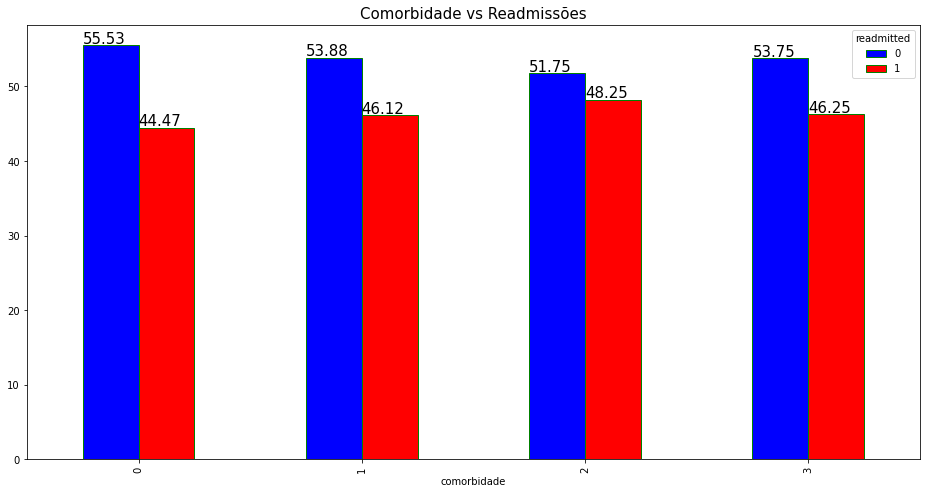

In [62]:
# Plot

# Prepara a figura a partir dos dados
fig = percent_com.plot(kind = 'bar', 
                       figsize = (16, 8), 
                       width = 0.5, 
                       edgecolor = 'g', 
                       color = ['b','r'])

# Desenha cada grupo
for i in fig .patches:
    fig.text(i.get_x() + 0.00, 
             i.get_height() + 0.3, 
             str(round((i.get_height()), 2)), 
             fontsize = 15, 
             color = 'black',
             rotation = 0)

# Título e Print
plt.title("Comorbidade vs Readmissões", fontsize = 15)
plt.show()

**Legenda do gráfico:**

 - Valor 0 indica que: Diabetes E problemas circulatórios não foram detectados de forma simultânea no paciente.
 - Valor 1 indica que: Pelo menos um diagnóstico de diabetes E problemas circulatórios foram detectados de forma simultânea no paciente.
 - Valor 2 indica que: Diabetes E pelo menos um diagnóstico de problemas circulatórios foram detectados de forma simultânea no paciente.
 - Valor 3 indica que: Pelo menos um diagnóstico de diabetes E pelo menos um dianóstico de problemas circulatórios foram detectados de forma simultânea no paciente.

**Variáveis de Dosagem de Medicamentos**

Verificando nosso conjunto de dados até aqui:

In [63]:
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,comorbidade
1,149190,55629189,Caucasian,Female,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,No,Up,No,No,No,No,Ch,Yes,1,1
2,64410,86047875,AfricanAmerican,Female,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,No,No,No,No,No,No,No,Yes,0,1
3,500364,82442376,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,No,Up,No,No,No,No,Ch,Yes,0,3
4,16680,42519267,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,No,Steady,No,No,No,No,Ch,Yes,0,1
5,35754,82637451,Caucasian,Male,[50-60),Outro,Casa,Outro,3,31,...,No,Steady,No,No,No,No,No,Yes,1,3


> O conjunto de dados contém 23 recursos para 23 medicamentos que indicam, para cada um deles, se uma alteração no medicamento foi feita ou não durante a atual internação do paciente. 

**Vamos plotar algumas variáveis que indicam uso de medicamento**

Text(0, 0.5, 'Count')

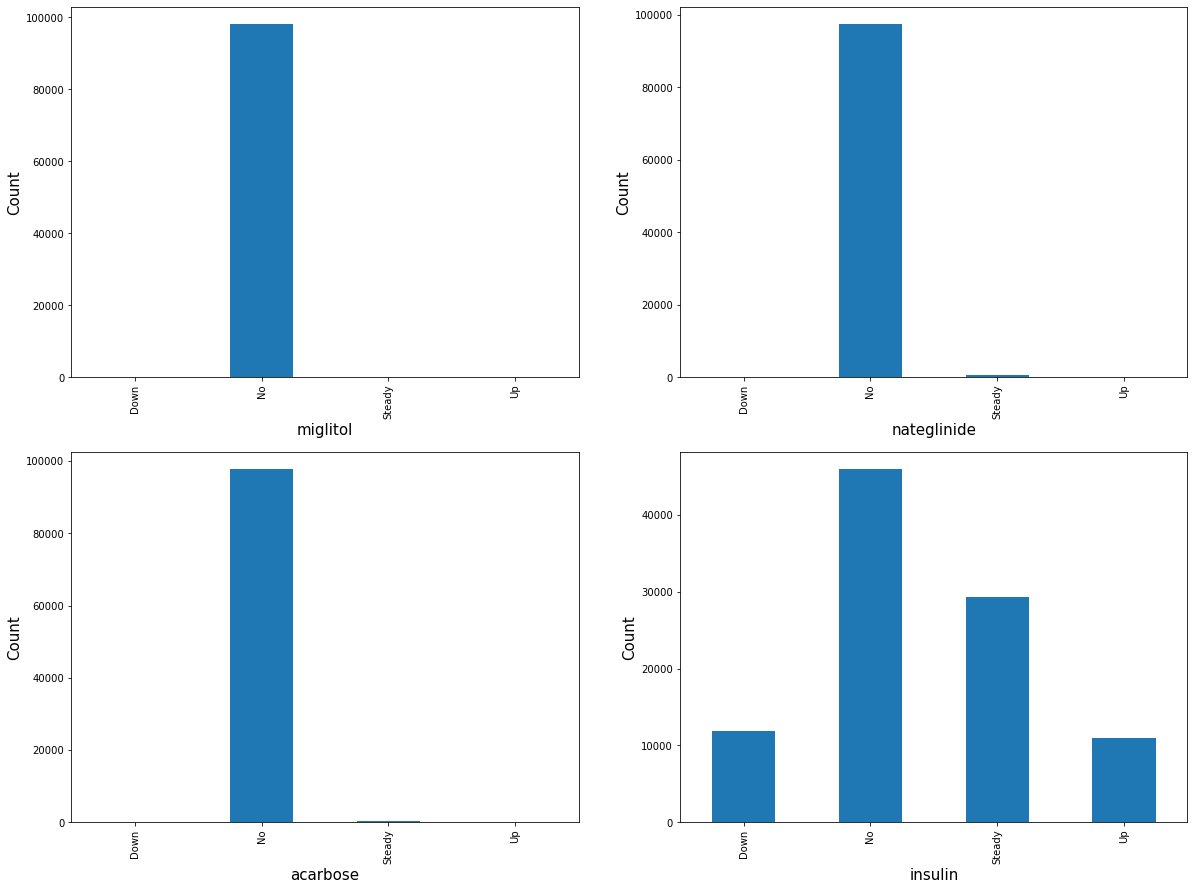

In [64]:
# Plot
fig = plt.figure(figsize = (20,15))

ax1 = fig.add_subplot(221)
ax1 = dados.groupby('miglitol').size().plot(kind = 'bar')
plt.xlabel('miglitol', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

ax2 = fig.add_subplot(222)
ax2 = dados.groupby('nateglinide').size().plot(kind = 'bar')
plt.xlabel('nateglinide', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

ax3 = fig.add_subplot(223)
ax3 = dados.groupby('acarbose').size().plot(kind = 'bar')
plt.xlabel('acarbose', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

ax4 = fig.add_subplot(224)
ax4 = dados.groupby('insulin').size().plot(kind = 'bar')
plt.xlabel('insulin', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

Podemos contar quantas alterações foram feitas no total para cada paciente e criamos um novo atributo. Isso pode ajudar a descobrir uma relação com o número de alterações, independentemente de qual medicamento foi alterado.

Além disso, podemos criar um novo atributo indicando o total de medicamentos que cada paciente consumiu durante a internação. E então avaliamos se há relação do total com a readmissão.

In [65]:
# Shape
dados.shape

(98052, 42)

In [66]:
dados.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'comorbidade'],
      dtype='object')

In [67]:
# Lista com os nomes das variáveis de medicamentos (3 variáveis já tinham sido removidas)
medicamentos = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
                'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
                'glimepiride-pioglitazone', 'metformin-pioglitazone']

In [68]:
# Loop para ajustar o valor das variáveis
for col in medicamentos:
    if col in dados.columns:
        colname = str(col) + 'temp'
        dados[colname] = dados[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

In [69]:
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,rosiglitazonetemp,acarbosetemp,miglitoltemp,troglitazonetemp,tolazamidetemp,insulintemp,glyburide-metformintemp,glipizide-metformintemp,glimepiride-pioglitazonetemp,metformin-pioglitazonetemp
1,149190,55629189,Caucasian,Female,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,0,0,0,0,0,1,0,0,0,0
2,64410,86047875,AfricanAmerican,Female,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,0,0,0,0,0,1,0,0,0,0
4,16680,42519267,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,0,0,0,0,0,0,0,0,0,0
5,35754,82637451,Caucasian,Male,[50-60),Outro,Casa,Outro,3,31,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Cria uma variável para receber a contagem por paciente
dados['num_alt_dosagem_med'] = 0

In [71]:
# Contagem de modificações na dosagem de medicamentos
for col in medicamentos:
    if col in dados.columns:
        colname = str(col) + 'temp'
        dados['num_alt_dosagem_med'] = dados['num_alt_dosagem_med'] + dados[colname]
        del dados[colname]

In [72]:
# Verifica o total por modificações na dosagem de medicamentos
dados.num_alt_dosagem_med.value_counts()

0    71309
1    25350
2     1281
3      107
4        5
Name: num_alt_dosagem_med, dtype: int64

In [73]:
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,comorbidade,num_alt_dosagem_med
1,149190,55629189,Caucasian,Female,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,Up,No,No,No,No,Ch,Yes,1,1,1
2,64410,86047875,AfricanAmerican,Female,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,No,No,No,No,No,No,Yes,0,1,0
3,500364,82442376,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,Up,No,No,No,No,Ch,Yes,0,3,1
4,16680,42519267,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,Steady,No,No,No,No,Ch,Yes,0,1,0
5,35754,82637451,Caucasian,Male,[50-60),Outro,Casa,Outro,3,31,...,Steady,No,No,No,No,No,Yes,1,3,0


Vamos **alterar o valor das colunas dos medicamentos** para refletir se esse medicamento está sendo administrado a um paciente ou não.

In [74]:
# Recoding das colunas de medicamentos
for col in medicamentos:
    if col in dados.columns:
        dados[col] = dados[col].replace('No', 0)
        dados[col] = dados[col].replace('Steady', 1)
        dados[col] = dados[col].replace('Up', 1)
        dados[col] = dados[col].replace('Down', 1) 

Agora, criamos mais uma coluna para refletir **quantos medicamentos estão sendo administrados a um paciente**.

In [75]:
# Variável com a contagem de medicamentos por paciente
dados['num_med'] = 0

In [76]:
# Carregamos a nova variável
for col in medicamentos:
    if col in dados.columns:
        dados['num_med'] = dados['num_med'] + dados[col]

In [77]:
# Verifica o total de medicamentos
dados['num_med'].value_counts()

1    45447
0    22702
2    21056
3     7485
4     1300
5       57
6        5
Name: num_med, dtype: int64

Depois de criar essas duas colunas, podemos **remover as colunas dos medicamentos**.

In [78]:
# Remove as colunas de medicamentos
dados = dados.drop(columns = medicamentos)

In [79]:
# Shape
dados.shape

(98052, 24)

In [80]:
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,comorbidade,num_alt_dosagem_med,num_med
1,149190,55629189,Caucasian,Female,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,0,9,None,None,Ch,Yes,1,1,1,1
2,64410,86047875,AfricanAmerican,Female,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,1,6,None,None,No,Yes,0,1,0,1
3,500364,82442376,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,0,7,None,None,Ch,Yes,0,3,1,1
4,16680,42519267,Caucasian,Male,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,0,5,None,None,Ch,Yes,0,1,0,2
5,35754,82637451,Caucasian,Male,[50-60),Outro,Casa,Outro,3,31,...,0,9,None,None,No,Yes,1,3,0,1


In [81]:
# Variáveis
dados.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
change                      object
diabetesMed                 object
readmitted                   int64
comorbidade                  int64
num_alt_dosagem_med          int64
num_med                      int64
dtype: object

**Vamos fazer o recoding de algumas variáveis categóricas**

In [82]:
# Recoding de variáveis categóricas binárias
dados['change'] = dados['change'].replace('Ch', 1)
dados['change'] = dados['change'].replace('No', 0)
dados['gender'] = dados['gender'].replace('Male', 1)
dados['gender'] = dados['gender'].replace('Female', 0)
dados['diabetesMed'] = dados['diabetesMed'].replace('Yes', 1)
dados['diabetesMed'] = dados['diabetesMed'].replace('No', 0)

In [83]:
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,comorbidade,num_alt_dosagem_med,num_med
1,149190,55629189,Caucasian,0,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,0,9,None,None,1,1,1,1,1,1
2,64410,86047875,AfricanAmerican,0,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,1,6,None,None,0,1,0,1,0,1
3,500364,82442376,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,0,7,None,None,1,1,0,3,1,1
4,16680,42519267,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,0,5,None,None,1,1,0,1,0,2
5,35754,82637451,Caucasian,1,[50-60),Outro,Casa,Outro,3,31,...,0,9,None,None,0,1,1,3,0,1


Também reduziremos o **resultado do teste A1C e o resultado do teste sérico** de glicose em categorias de Normal, Anormal e Não Testado, com valores 1, 0 e -99, respectivamente.

In [84]:
# Recoding de variáveis categóricas (label encoding)
dados['A1Cresult'] = dados['A1Cresult'].replace('>7', 1)
dados['A1Cresult'] = dados['A1Cresult'].replace('>8', 1)
dados['A1Cresult'] = dados['A1Cresult'].replace('Norm', 0)
dados['A1Cresult'] = dados['A1Cresult'].replace('None', -99)
dados['max_glu_serum'] = dados['max_glu_serum'].replace('>200', 1)
dados['max_glu_serum'] = dados['max_glu_serum'].replace('>300', 1)
dados['max_glu_serum'] = dados['max_glu_serum'].replace('Norm', 0)
dados['max_glu_serum'] = dados['max_glu_serum'].replace('None', -99)

In [85]:
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,comorbidade,num_alt_dosagem_med,num_med
1,149190,55629189,Caucasian,0,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,0,9,-99,-99,1,1,1,1,1,1
2,64410,86047875,AfricanAmerican,0,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,1,6,-99,-99,0,1,0,1,0,1
3,500364,82442376,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,0,7,-99,-99,1,1,0,3,1,1
4,16680,42519267,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,0,5,-99,-99,1,1,0,1,0,2
5,35754,82637451,Caucasian,1,[50-60),Outro,Casa,Outro,3,31,...,0,9,-99,-99,0,1,1,3,0,1


Alguns pacientes no conjunto de dados tiveram mais de um encontro (consulta). 

Não podemos contá-los como encontros independentes, porque isso influencia os resultados para aqueles pacientes que tiveram vários encontros. Assim, tentamos várias técnicas para recolher e consolidar vários encontros para o mesmo paciente, como:

- Considerar a permanência média no hospital em vários encontros.
- Considerar a porcentagem de alterações na medicação em vários encontros.
- Considerar o número total de encontros para substituir o ID exclusivo do encontro.
- Considerar a combinação de diagnósticos em vários encontros como uma lista.

Por fim, o ideal foi deixar apenas um registro de encontro para cada paciente e optamos por manter o primeiro.

In [86]:
# Removendo duplicidades por id de paciente, mantendo o primeiro registro
dados = dados.drop_duplicates(subset = ['patient_nbr'], keep = 'first')

In [87]:
# Shape
dados.shape

(68629, 24)

In [88]:
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,comorbidade,num_alt_dosagem_med,num_med
1,149190,55629189,Caucasian,0,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,0,9,-99,-99,1,1,1,1,1,1
2,64410,86047875,AfricanAmerican,0,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,1,6,-99,-99,0,1,0,1,0,1
3,500364,82442376,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,0,7,-99,-99,1,1,0,3,1,1
4,16680,42519267,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,0,5,-99,-99,1,1,0,1,0,2
5,35754,82637451,Caucasian,1,[50-60),Outro,Casa,Outro,3,31,...,0,9,-99,-99,0,1,1,3,0,1


In [89]:
# Info
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68629 entries, 1 to 101765
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              68629 non-null  int64 
 1   patient_nbr               68629 non-null  int64 
 2   race                      68629 non-null  object
 3   gender                    68629 non-null  int64 
 4   age                       68629 non-null  object
 5   admission_type_id         68629 non-null  object
 6   discharge_disposition_id  68629 non-null  object
 7   admission_source_id       68629 non-null  object
 8   time_in_hospital          68629 non-null  int64 
 9   num_lab_procedures        68629 non-null  int64 
 10  num_procedures            68629 non-null  int64 
 11  num_medications           68629 non-null  int64 
 12  number_outpatient         68629 non-null  int64 
 13  number_emergency          68629 non-null  int64 
 14  number_inpatient     

In [90]:
# Salvando o dataset
dados.to_csv('dados/df_dados.csv', index = False)

# 2.0 Análise Exploratória

#### Total de Medicamentos Consumidos Por Faixa Etária

> A faixa etária de pacientes entre 70-80 é a que mais consome medicamentos.

In [91]:
# Carregando os dados
dados = pd.read_csv("dados/df_dados.csv")

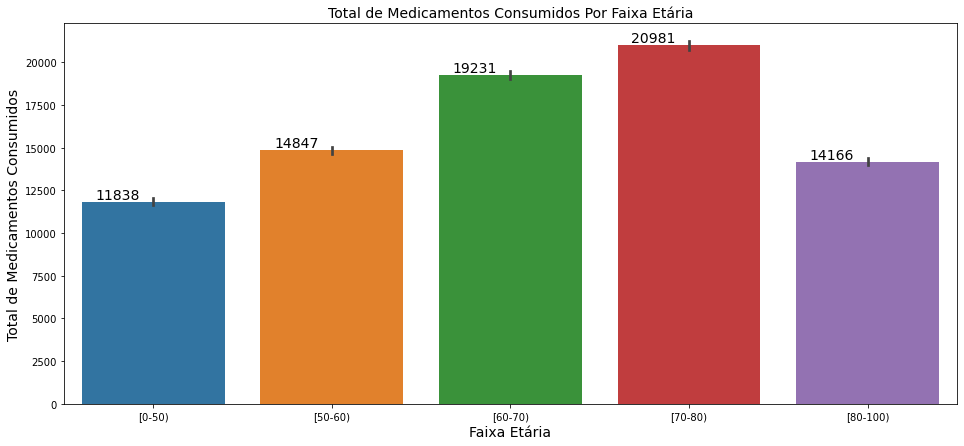

In [92]:
# Tamanho da figura
plt.figure(figsize = (16,7))

# Criação do gráfico de barras
figx = sns.barplot(x = 'age', y = 'num_med', estimator = np.sum, data = dados)

# Label do eixo x
plt.xlabel("Faixa Etária", fontsize = 14, color = 'black')

# Label do eixo y
plt.ylabel("Total de Medicamentos Consumidos", fontsize = 14, color = 'black')

# Título
plt.title("Total de Medicamentos Consumidos Por Faixa Etária", fontsize = 14, color = 'black')

# Coloca os totais em cada uma das barras como labels
for p in figx.patches:
    figx.annotate('{:.0f}'.format(p.get_height()), 
                  (p.get_x() + 0.2, p.get_height()), 
                  ha = 'center', 
                  va = 'bottom', 
                  fontsize = 14,
                  color = 'black')

# Mostra o gráfico
plt.show()

#### Total de Readmissões de Pacientes Diabéticos Por Gênero

> Pacientes do sexo feminino tem número maior de readmissões.

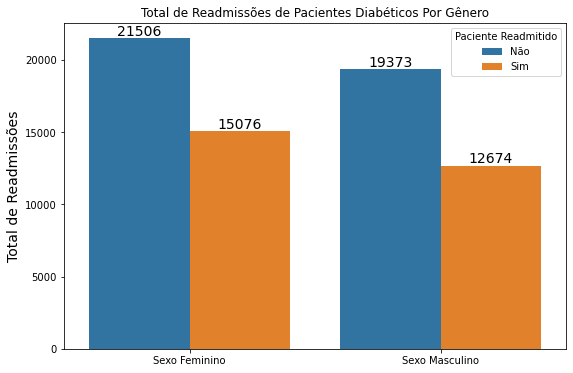

In [93]:
# Criação do gráfico de barras com label encoding
figx = sns.countplot(x = [('Sexo Feminino' if x == 0 else 'Sexo Masculino') for x in dados['gender']], 
                     hue = 'readmitted', 
                     data = dados) 

# Tamanho da figura em polegadas
figx.figure.set_size_inches(9,6)

# Legenda
figx.legend(title = 'Paciente Readmitido', labels = ('Não', 'Sim'))

# Label do eixo y
plt.ylabel("Total de Readmissões", fontsize = 14, color = 'black')

# Título
figx.axes.set_title('Total de Readmissões de Pacientes Diabéticos Por Gênero')

# Coloca os totais em cada uma das barras como labels
for p in figx.patches:
    figx.annotate('{:.0f}'.format(p.get_height()), 
                  (p.get_x() + 0.2, p.get_height()), 
                  ha = 'center', 
                  va = 'bottom', 
                  fontsize = 14,
                  color = 'black')
    
# Mostra o gráfico
plt.show()

#### Total de Readmissões de Pacientes Diabéticos Por Faixa Etária

> A faixa etária de pacientes entre 70-80 é a que tem o maior número de readmissões.

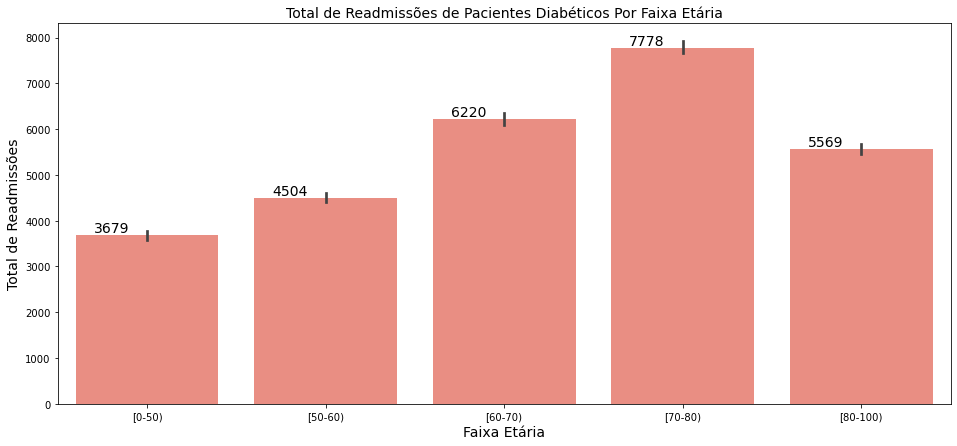

In [94]:
# Tamanho da figura
plt.figure(figsize = (16,7))

# Criação do gráfico de barras
figx = sns.barplot(x = 'age', y = 'readmitted', estimator = np.sum, data = dados, color = 'salmon')

# Label do eixo x
plt.xlabel("Faixa Etária", fontsize = 14, color = 'black')

# Label do eixo y
plt.ylabel("Total de Readmissões", fontsize = 14, color = 'black')

# Título
plt.title("Total de Readmissões de Pacientes Diabéticos Por Faixa Etária", fontsize = 14, color = 'black')

# Coloca os totais em cada uma das barras como labels
for p in figx.patches:
    figx.annotate('{:.0f}'.format(p.get_height()), 
                  (p.get_x() + 0.2, p.get_height()), 
                  ha = 'center', 
                  va = 'bottom', 
                  fontsize = 14,
                  color = 'black')

# Mostra o gráfico
plt.show()

#### Percentual de Readmissões/Não Readmissões de Pacientes Diabéticos Por Faixa Etária

> A faixa etária de pacientes entre 70-80 tem o maior percentual de readmissões, enquanto a faixa etária de 0-50 anos tem o menor percentual.

In [95]:
# Primeiro calculamos os percentuais
percentual_idade_readmissao = pd.crosstab(dados.age , dados.readmitted, margins = True, normalize = 'index') * 100
percentual_idade_readmissao

readmitted,0,1
age,,
[0-50),64.915125,35.084875
[50-60),62.463539,37.536461
[60-70),59.647074,40.352926
[70-80),55.912028,44.087972
[80-100),57.449572,42.550428
All,59.565198,40.434802


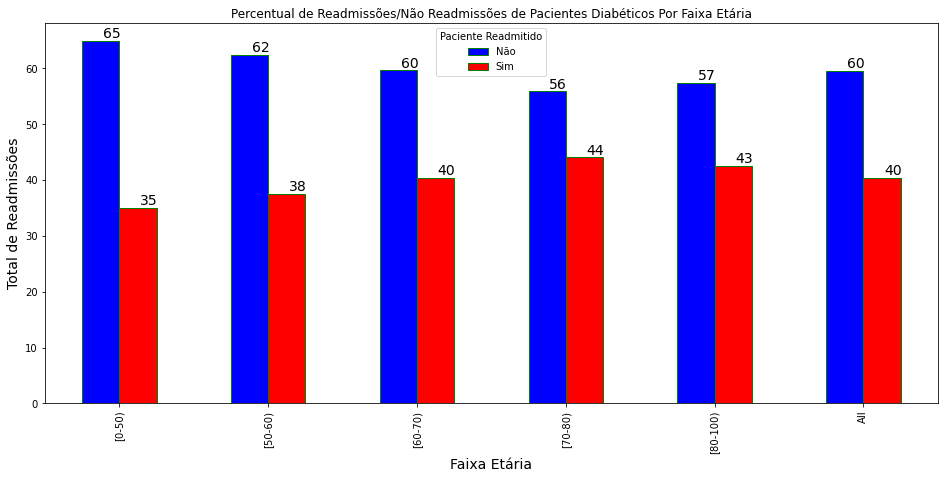

In [96]:
# Cria o gráfico
# Observe que chamamos o plot a partir do dataframe usando nesse caso o Matplotlib
fig = percentual_idade_readmissao.plot(kind = 'bar', 
                                       figsize = (16, 7), 
                                       width = 0.5,
                                       edgecolor = 'g', 
                                       color = ['b', 'r'])

# Legenda
plt.legend(title = 'Paciente Readmitido', labels = ('Não', 'Sim'))

# Label do eixo x
plt.xlabel("Faixa Etária", fontsize = 14, color = 'black')

# Label do eixo y
plt.ylabel("Total de Readmissões", fontsize = 14, color = 'black')

# Título
plt.title("Percentual de Readmissões/Não Readmissões de Pacientes Diabéticos Por Faixa Etária", fontsize = 12)

# Coloca os totais em cada uma das barras como labels
for p in fig.patches:
    fig.annotate('{:.0f}'.format(p.get_height()), 
                 (p.get_x() + 0.2, p.get_height()), 
                 ha = 'center', 
                 va = 'bottom', 
                 fontsize = 14,
                 color = 'black')

# Mostra o gráfico
plt.show()

#### Total de Readmissões de Pacientes Diabéticos Por Gênero, Por Idade e Por Tipo de Admissão

> Mulheres na faixa etária de 70-80 anos tem um número maior de readmissões por emergência.

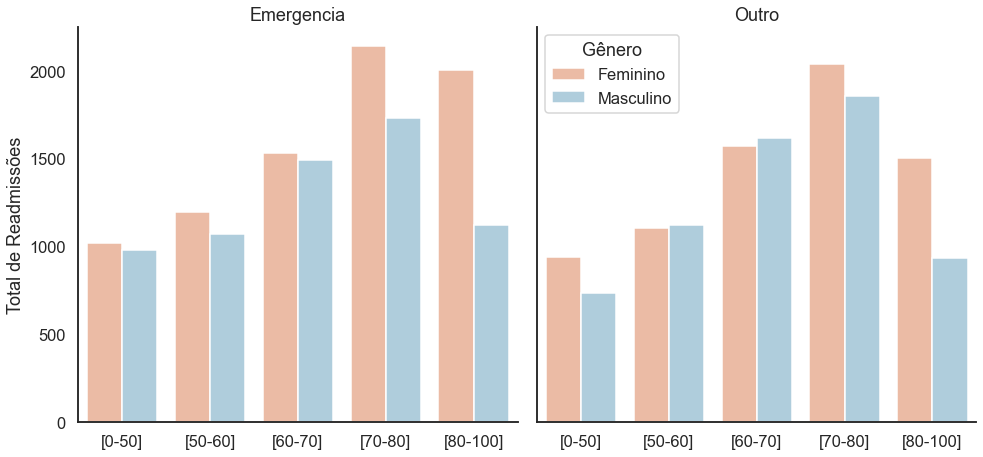

In [97]:
# Vamos incluir o background
sns.set(style = "white", context = "talk")

# Criação do gráfico de barras com catplot
g = sns.catplot(x = 'age', 
                y = 'readmitted', 
                hue = 'gender', 
                col = 'admission_type_id',
                estimator = np.sum, 
                data = dados, 
                palette = "RdBu", 
                kind = "bar",
                height = 7, 
                aspect = 1,
                legend = False,
                ci = None)

# Labels
(g.set_axis_labels("", "Total de Readmissões")
 .set_xticklabels(["[0-50]", "[50-60]", "[60-70]", "[70-80]", "[80-100]"])
 .set_titles("{col_name}"))

# Legenda
plt.legend(title = 'Gênero', loc = 'upper left', labels = ['Feminino', 'Masculino'])

# Mostra o gráfico
plt.show(g)

#### Total de Readmissões Por Gênero e Por Raça

> Mulheres Caucasianas são a maioria entre as mulheres readmitidas.

https://pt.wikipedia.org/wiki/Ra%C3%A7a_caucasiana

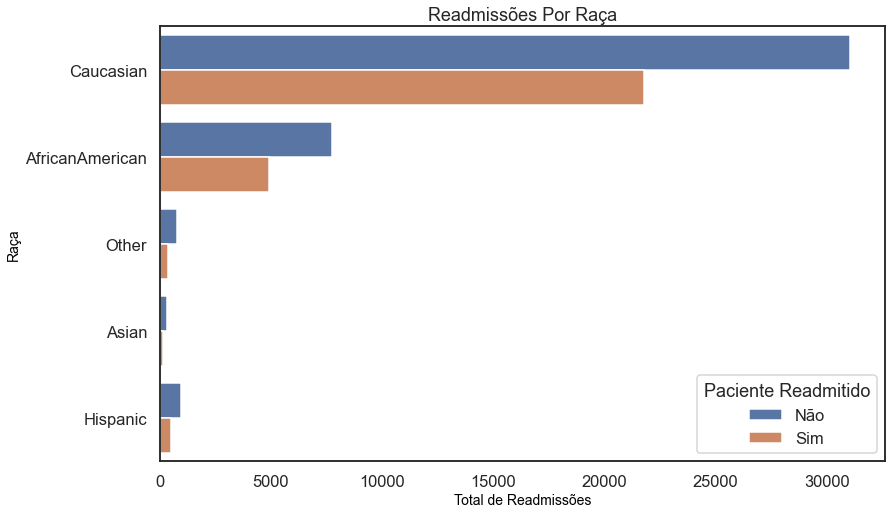

In [98]:
# Cria o gráfico

figx = sns.countplot(y = 'race', hue = 'readmitted', data = dados) 

# Label do eixo x
plt.xlabel("Total de Readmissões", fontsize = 14, color = 'black')

# Label do eixo y
plt.ylabel("Raça", fontsize = 14, color = 'black')

# Tamanho do gráfico
figx.figure.set_size_inches(13, 8)

# Legenda
figx.legend(title = 'Paciente Readmitido', labels = ('Não', 'Sim'))

# Título
figx.axes.set_title('Readmissões Por Raça')

# Mostra o gráfico
plt.show()

In [99]:
# Valores únicos de raça
dados['race'].unique()

array(['Caucasian', 'AfricanAmerican', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [100]:
# Cria um dataframe temporário para ajustar o label da variável target para o plot
df_temp = dados

In [101]:
# Faz o mapeamento de 0 e 1 para labels
df_temp["readmitted"] = df_temp["readmitted"].map({0: "Não Readmitido", 1: "Readmitido"})

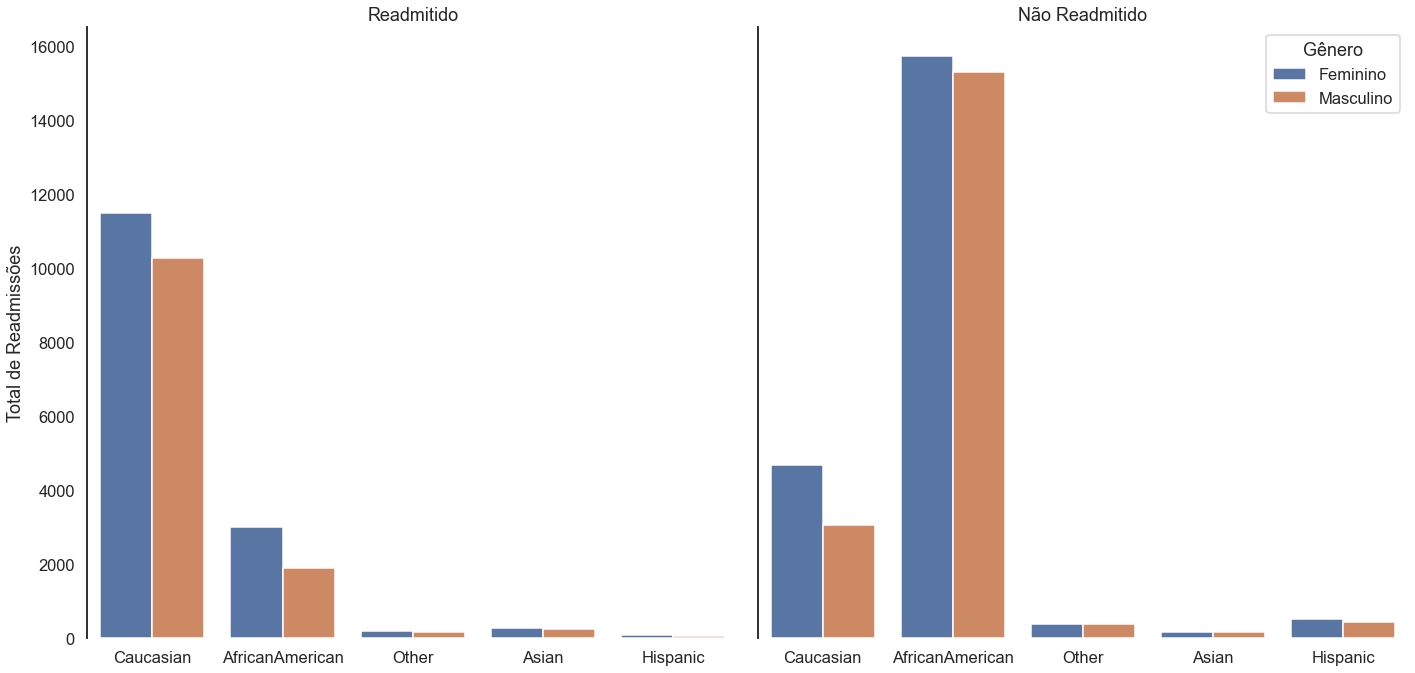

In [102]:
# Remove o background
sns.set(style = "white", context = "talk")

# Cria uma função para personalizar a quantidade de parâmetros
def countplot(x, hue, **kwargs):
    sns.countplot(x = x, hue = hue, **kwargs)

# Cria um facetgrid (usando o dataframe temporário)
grid = sns.FacetGrid(data = df_temp, col = 'readmitted', height = 10, aspect = 1)

# Mapeamento do facetgrid às variáveis
fig = grid.map(countplot, 'race', 'gender', palette = 'deep')

# Labels
(fig.set_axis_labels("", "Total de Readmissões")
 .set_xticklabels(["Caucasian", "AfricanAmerican", "Other", "Asian", "Hispanic"])
 .set_titles('{col_name}'))

# Legenda
plt.legend(title = 'Gênero', loc = 'upper right', labels = ['Feminino', 'Masculino'])

# Remove os contornos do gráfico
sns.despine(bottom = True)

#### Número de Visitas x Comorbidade

>Pacientes com comorbidade tem o maior número de visitas.

In [103]:
# Criamos a tabela de contigência
num_visitas_comorbidade = pd.crosstab(dados.number_inpatient, dados.comorbidade).sum()
num_visitas_comorbidade

comorbidade
0    15483
1    13032
2    27076
3    13038
dtype: int64

In [104]:
# Tipo
type(num_visitas_comorbidade)

pandas.core.series.Series

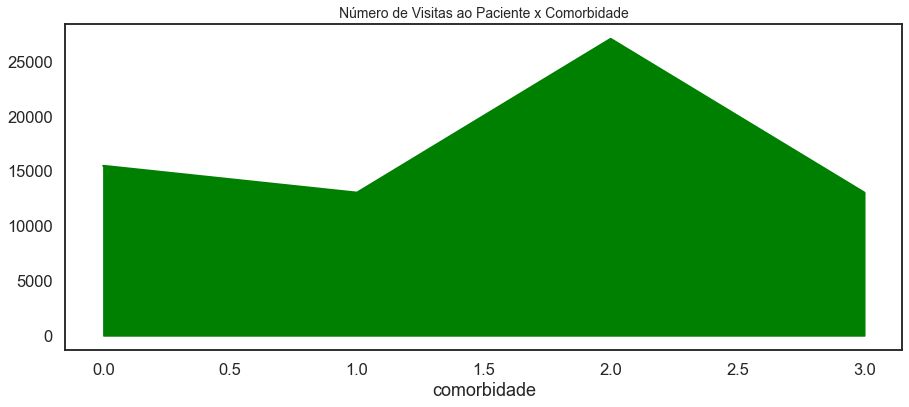

In [105]:
# Cria o gráfico
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.html
fig = num_visitas_comorbidade.plot(kind = 'area',
                                   figsize = (15,6),
                                   color = 'Green')

# Coloca os totais em cada uma das barras como labels
for p in fig.patches:
    fig.annotate('{:.0f}'.format(p.get_height()), 
                 (p.get_x() + 0.2, p.get_height()), 
                 ha = 'center', 
                 va = 'bottom', 
                 fontsize = 14,
                 color = 'black')

# Título
plt.title("Número de Visitas ao Paciente x Comorbidade", fontsize = 14)
plt.show()

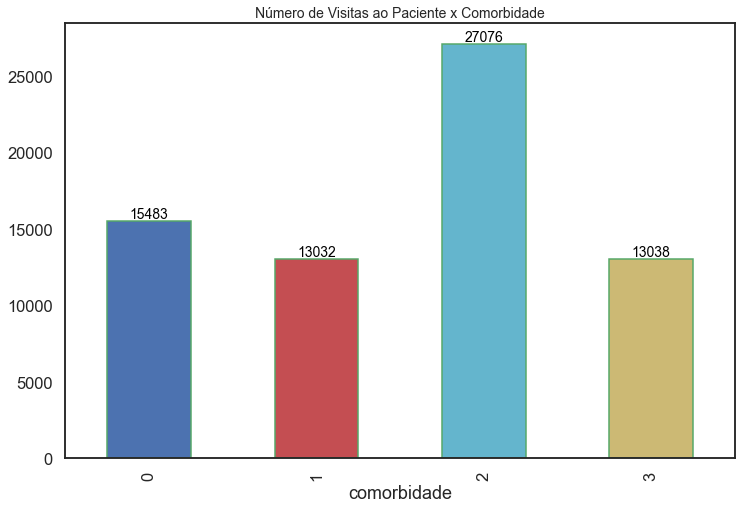

In [106]:
# Vamos remover as linhas do background
sns.set(style = "white", context = "talk")

# Cria o gráfico
fig = num_visitas_comorbidade.plot(kind = 'bar',
                                   figsize = (12,8), 
                                   width = 0.5,
                                   edgecolor = 'g', 
                                   color = ['b','r','c','y'],
                                   rot = 90)

# Coloca os totais em cada uma das barras como labels
for p in fig.patches:
    fig.annotate('{:.0f}'.format(p.get_height()), 
                 (p.get_x() + 0.25, p.get_height()), 
                 ha = 'center', 
                 va = 'bottom', 
                 fontsize = 14,
                 color = 'black')

# Título
plt.title("Número de Visitas ao Paciente x Comorbidade", fontsize = 14)

# Mostra o gráfico
plt.show()

#### Proporção de Readmissões Pelo Número de Visitas Antes da Alta

> Quanto mais visitas o paciente recebeu antes da alta, maior foi o volume de readmissões. Ou seja, quanto mais visitas o paciente recebe, maiores as chances de readmissão.

In [107]:
# Tabela de contingência
percent_visitas_readm = pd.crosstab(dados.number_inpatient , dados.readmitted, normalize = 'index')*100
percent_visitas_readm

readmitted,Não Readmitido,Readmitido
number_inpatient,,
0,62.088788,37.911212
1,45.879397,54.120603
2,34.692557,65.307443
3,29.363450,70.636550
4,24.137931,75.862069
5,20.388350,79.611650
6,12.500000,87.500000
7,10.000000,90.000000
8,16.666667,83.333333


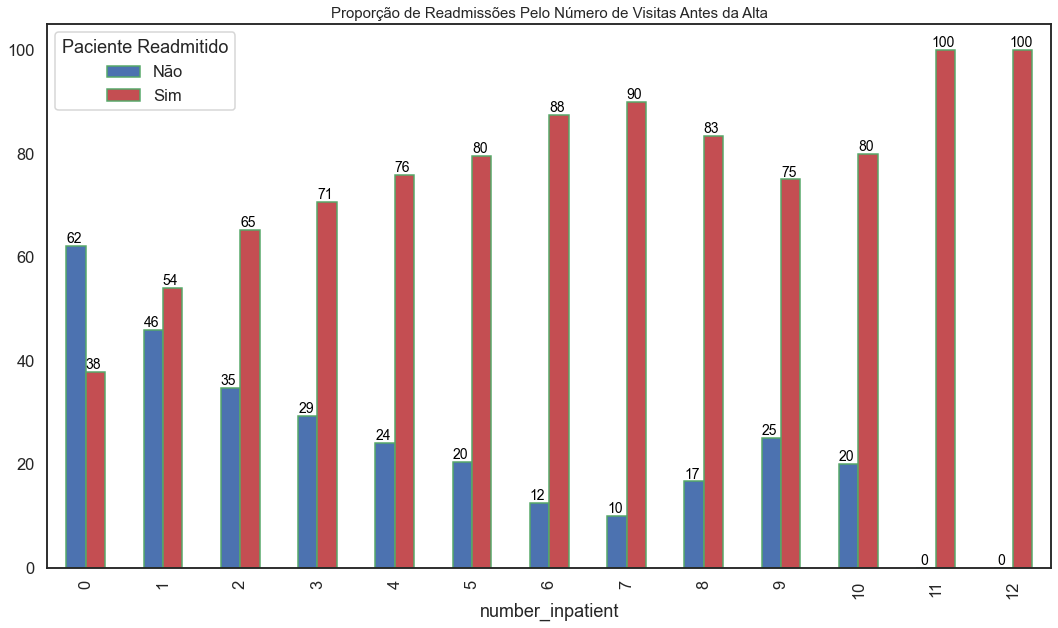

In [108]:
# Cria o gráfico
fig = percent_visitas_readm.plot(kind = 'bar', figsize = (18,10), width = 0.5, edgecolor = 'g', color = ['b','r'])

# Coloca os totais em cada uma das barras como labels
for p in fig.patches:
    fig.annotate('{:.0f}'.format(p.get_height()), 
                 (p.get_x() + 0.1, p.get_height()), 
                 ha = 'center', 
                 va = 'bottom', 
                 fontsize = 14,
                 color = 'black')

# Título
plt.title("Proporção de Readmissões Pelo Número de Visitas Antes da Alta", fontsize = 15)

# Legenda
fig.legend(title = 'Paciente Readmitido', labels = ('Não', 'Sim'))

# Mostra o gráfico
plt.show()

## Análise Univariada

#### Distribuição de Frequência do Número de Medicamentos Consumidos

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Número de Medicamentos Consumidos', ylabel='Density'>

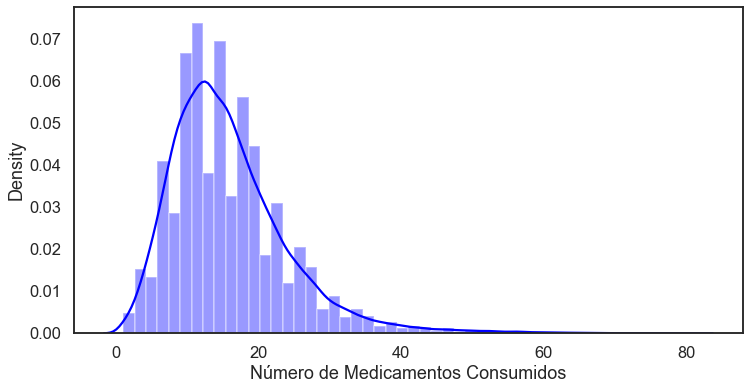

In [109]:
# Tamanho da figura
plt.figure(figsize = (12,6))

# Cria o gráfico
sns.distplot(dados['num_medications'], hist = True, color = 'Blue', axlabel = "Número de Medicamentos Consumidos")

In [110]:
# Estatísticas
dados['num_medications'].describe()

count    68629.000000
mean        15.806481
std          8.289790
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max         81.000000
Name: num_medications, dtype: float64

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_medications'>

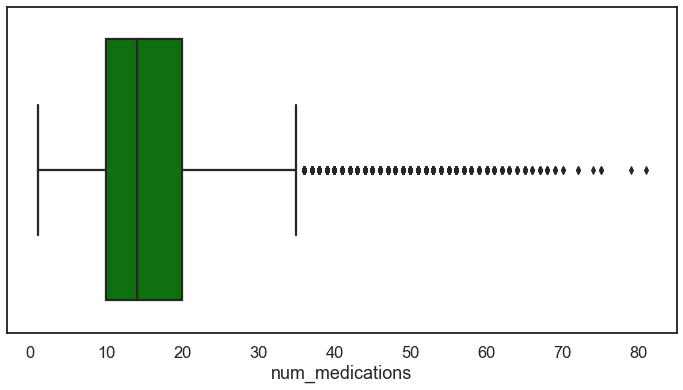

In [111]:
# Tamanho da figura
plt.figure(figsize = (12,6))

# Cria o gráfico
sns.boxplot(dados['num_medications'], color = 'Green')

#### Stacked Histogramas

<AxesSubplot:ylabel='Frequency'>

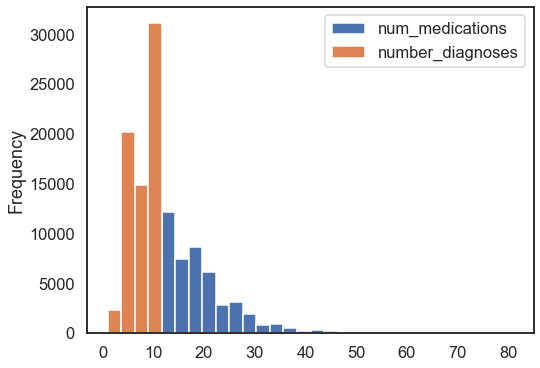

In [112]:
# Dois histogramas para duas variáveis no mesmo gráfico
dados[["num_medications", "number_diagnoses"]].plot(bins = 30, kind = "hist", figsize = (8,6))

#### Histogramas da Mesma Variável Por Diferentes Classes

array([<AxesSubplot:title={'center':'Não Readmitido'}>,
       <AxesSubplot:title={'center':'Readmitido'}>], dtype=object)

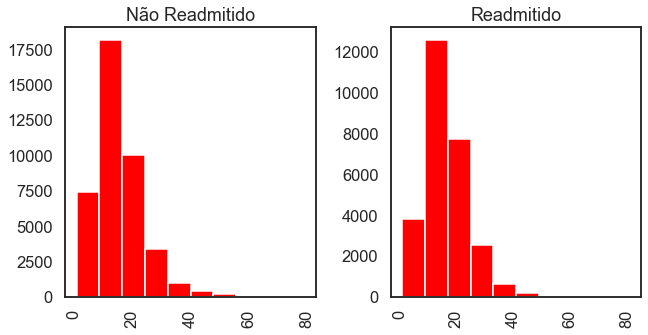

In [113]:
dados[["num_medications"]].hist(by = dados.readmitted, figsize = (10,5), color = 'Red')

#### Comportamento do Paciente Por Procedimentos Clínicos


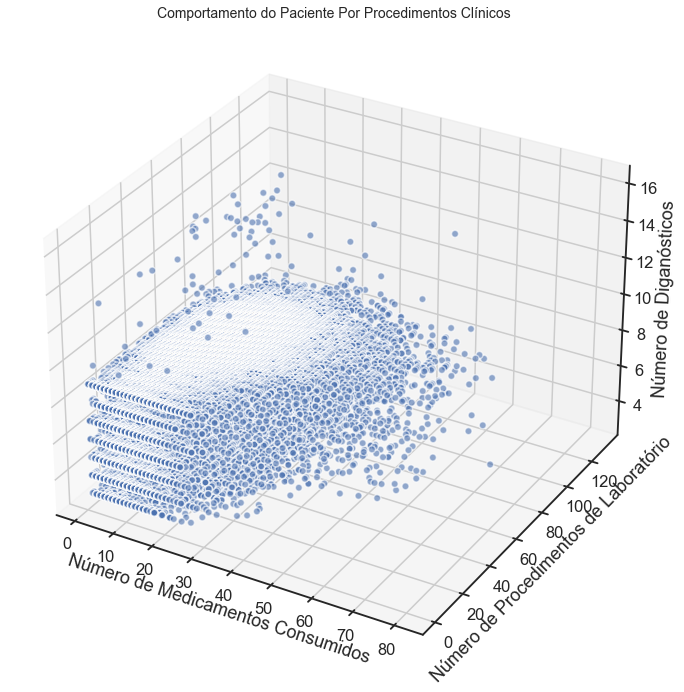

In [114]:
# Projeção 3D

# Tamanho da figura
fig = plt.figure(figsize = (14, 12))

# Subplots
ax = fig.add_subplot(111, projection = '3d')

# Dimensões
xs = dados['num_medications']
ys = dados['num_lab_procedures']
zs = dados['number_diagnoses']

# Gráfico de pontos
ax.scatter(xs, ys, zs, s = 50, alpha = 0.6, edgecolors = 'w')

# Labels
ax.set_xlabel('Número de Medicamentos Consumidos')
ax.set_ylabel('Número de Procedimentos de Laboratório')
ax.set_zlabel('Número de Diganósticos')

# Título
plt.title("Comportamento do Paciente Por Procedimentos Clínicos", fontsize = 14)

# Mostra o gráfico
plt.show()

## Pré-Processamento de Dados

In [115]:
# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 14,6

In [116]:
# Carregando os dados
dados = pd.read_csv("dados/df_dados.csv")

In [117]:
# Visualizando os dados
dados.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,comorbidade,num_alt_dosagem_med,num_med
0,149190,55629189,Caucasian,0,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,...,0,9,-99,-99,1,1,1,1,1,1
1,64410,86047875,AfricanAmerican,0,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,...,1,6,-99,-99,0,1,0,1,0,1
2,500364,82442376,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,...,0,7,-99,-99,1,1,0,3,1,1
3,16680,42519267,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,...,0,5,-99,-99,1,1,0,1,0,2
4,35754,82637451,Caucasian,1,[50-60),Outro,Casa,Outro,3,31,...,0,9,-99,-99,0,1,1,3,0,1


In [118]:
# Remove as variáveis de ID
dados.drop(['encounter_id', 'patient_nbr'], axis = 1, inplace = True)

In [119]:
# Shape
dados.shape

(68629, 22)

In [120]:
# Vamos armazenar 'readmitted' no rótulo (label) e o restante das colunas em dados_final
label = dados['readmitted']
dados_final = dados.drop(['readmitted'], axis = 1)

In [121]:
# Vamos criar variáveis dummy para variáveis categóricas
dados_final = pd.get_dummies(dados_final)

In [122]:
# Shape
dados_final.shape

(68629, 33)

In [123]:
# Visualizando os dados
dados_final.head()

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,age_[60-70),age_[70-80),age_[80-100),admission_type_id_Emergencia,admission_type_id_Outro,discharge_disposition_id_Casa,discharge_disposition_id_Outro,admission_source_id_Outro,admission_source_id_Recomendacao,admission_source_id_Sala_Emergencia
0,0,3,59,0,18,0,0,0,9,-99,...,0,0,0,1,0,1,0,0,0,1
1,0,2,11,5,13,2,0,1,6,-99,...,0,0,0,1,0,1,0,0,0,1
2,1,2,44,1,16,0,0,0,7,-99,...,0,0,0,1,0,1,0,0,0,1
3,1,1,51,0,8,0,0,0,5,-99,...,0,0,0,1,0,1,0,0,0,1
4,1,3,31,6,16,0,0,0,9,-99,...,0,0,0,0,1,1,0,1,0,0


**Vamos dividor os dados em treino e teste**

In [124]:
# Split dos dados
X_treino, X_teste, Y_treino, Y_teste = train_test_split(dados_final, 
                                                        label, 
                                                        test_size = .2, 
                                                        random_state = 0, 
                                                        stratify = label )

**Vamos padronizar os dados**

In [125]:
# Shape
print('O shape de X_treino : ', X_treino.shape)
print('O shape de Y_treino : ', Y_treino.shape)
print('O shape de X_teste : ', X_teste.shape)
print('O shape de Y_teste : ', Y_teste.shape)

O shape de X_treino :  (54903, 33)
O shape de Y_treino :  (54903,)
O shape de X_teste :  (13726, 33)
O shape de Y_teste :  (13726,)


In [126]:
# Cria o padronizador
scaler = StandardScaler()

In [127]:
# Treina o padronizador com o método fit() e aplica com o método transform() nos dados de treino.
# O método fit_transform() realiza as duas operações.
# O fit_transform deve ser feito nos dados de treino de X. Não precisamos fazer em y
X_treino_scaled = scaler.fit_transform(X_treino)

In [128]:
X_treino_scaled

array([[-0.93951573, -0.78411414,  1.14249657, ...,  2.36737722,
        -0.66771483, -1.08396458],
       [ 1.06437814,  3.27837699,  1.54297471, ..., -0.42240839,
        -0.66771483,  0.92253937],
       [ 1.06437814, -0.10703228, -0.30923666, ..., -0.42240839,
        -0.66771483,  0.92253937],
       ...,
       [ 1.06437814, -0.78411414, -1.76096989, ...,  2.36737722,
        -0.66771483, -1.08396458],
       [-0.93951573, -0.10703228,  0.84213798, ..., -0.42240839,
        -0.66771483,  0.92253937],
       [-0.93951573, -1.12265507, -0.35929642, ..., -0.42240839,
         1.49764533, -1.08396458]])

In [129]:
# Nos dados de teste, aplicamos apenas o transform()
X_teste_scaled = scaler.transform(X_teste)

In [130]:
X_teste_scaled

array([[-0.93951573, -0.78411414, -0.30923666, ..., -0.42240839,
         1.49764533, -1.08396458],
       [ 1.06437814, -0.78411414, -1.16025269, ..., -0.42240839,
        -0.66771483,  0.92253937],
       [-0.93951573,  3.27837699, -0.10899759, ..., -0.42240839,
        -0.66771483,  0.92253937],
       ...,
       [-0.93951573, -0.78411414,  0.09124148, ..., -0.42240839,
        -0.66771483,  0.92253937],
       [ 1.06437814,  1.58567236, -0.40935619, ..., -0.42240839,
        -0.66771483,  0.92253937],
       [ 1.06437814, -0.78411414,  0.84213798, ..., -0.42240839,
        -0.66771483,  0.92253937]])

# 3.0 Modelagem Preditiva

Criaremos diversos modelos preditivos e para cada um deles, teremos as seguintes atividades:

- Criação do modelo.
- Treinamento do modelo.
- Avaliação do modelo.
- Cálculo e interpretação das métricas.
- Extração da importância das variáveis.

Ao final, vamos comparar todos os modelos e usar o resultado para estratificar o risco, nosso objetivo final.

## Modelagem com Regressão Logística

Criação do Modelo de Regressão Lógística.

In [131]:
# Cria o modelo
modelo_lr = LogisticRegression(tol = 1e-7, penalty = 'l2', C = 0.0005, solver = 'liblinear')

# Treina o modelo
modelo_lr.fit(X_treino_scaled, Y_treino)

# Faz as previsões
lr_Y_pred = modelo_lr.predict(X_teste_scaled)

# Extrai as probabilidades (necessário para calcular o AUC)
lr_predict_proba = modelo_lr.predict_proba(X_teste_scaled)[:,1] 

**Avaliação do Modelo**

In [132]:
# Verificando a acurácia do modelo
# https://scikit-learn.org/stable/modules/model_evaluation.html

# Calcula o score com dados de teste
lr_accuracy = modelo_lr.score(X_teste_scaled, Y_teste) * 100

# Print
print("Acurácia do Modelo de Regressão Logística (%):", lr_accuracy)

Acurácia do Modelo de Regressão Logística (%): 61.627568118898445


**Matriz de Confusão e Métricas**

In [133]:
# Cria e imprime a matriz de confusão
conf_matriz_lr = confusion_matrix(Y_teste, lr_Y_pred)
print('\nMatriz de Confusão:\n', conf_matriz_lr)

# Calcula o total 
total1 = sum(sum(conf_matriz_lr))

# Calcula a acurácia
accuracy_lr = (conf_matriz_lr[0,0] + conf_matriz_lr[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_lr = conf_matriz_lr[0,0] / (conf_matriz_lr[0,0] + conf_matriz_lr[0,1])
sensi_lr = conf_matriz_lr[1,1] / (conf_matriz_lr[1,0] + conf_matriz_lr[1,1])

# Print
print('\nAcurácia : ', accuracy_lr)
print('Sensibilidade :', sensi_lr)
print('Especificidade :', speci_lr)


Matriz de Confusão:
 [[7356  820]
 [4447 1103]]

Acurácia :  0.6162756811889845
Sensibilidade : 0.19873873873873873
Especificidade : 0.899706457925636


A **sensibilidade** (também chamada de taxa de verdadeiros positivos, recall ou probabilidade de detecção em alguns campos) mede a proporção de positivos reais que são corretamente identificados como tais (por exemplo, a porcentagem de pessoas doentes corretamente identificadas como tendo o doença).

A **especificidade** (também chamada de taxa de verdadeiros negativos) mede a proporção de negativos reais que são identificados corretamente como tal (por exemplo, a porcentagem de pessoas saudáveis que são identificadas corretamente como sem a condição).

**Plot da Matriz de Confusão**

Text(0.5, 1.0, 'Acurácia: 0.6162756811889845')

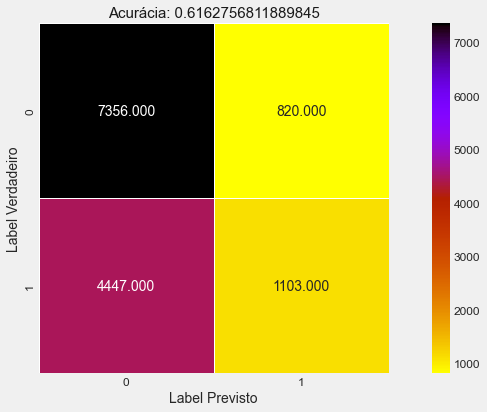

In [134]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(Y_teste, lr_Y_pred), 
            annot = True, 
            fmt = ".3f", 
            linewidths = .5, 
            square = True, 
            cmap = 'gnuplot_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro');
plt.xlabel('Label Previsto');
all_sample_title = 'Acurácia: {0}'.format(modelo_lr.score(X_teste_scaled, Y_teste))
plt.title(all_sample_title, size = 15)

**Curva ROC e Score AUC**

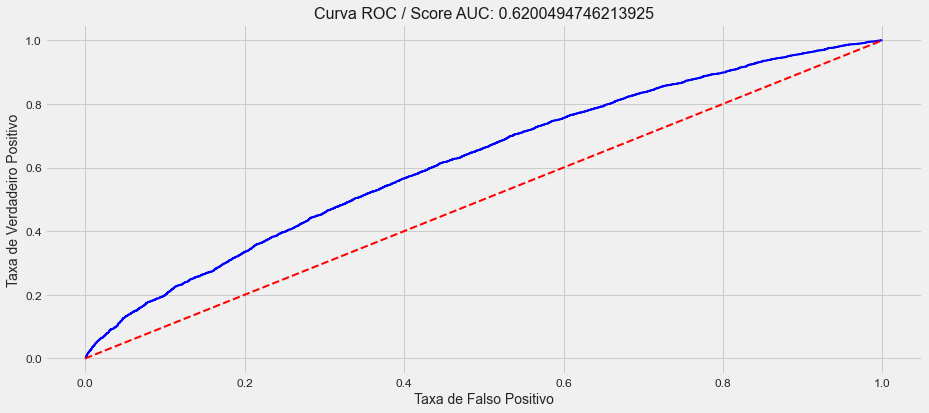

In [135]:
# Extrai as métricas para a Curva ROC
lr_fpr, lr_tpr, thresholds = roc_curve(Y_teste, lr_predict_proba)

# Calcula o Score AUC
lr_roc_auc = auc(lr_fpr, lr_tpr)

# Cria a figura para o Plot
plt.figure()

# Plot da Curva ROC
plt.plot(lr_fpr, lr_tpr, color = 'blue', lw = 2, label = 'Curva ROC')

# Cria a linha base (linha tracejada em vermelho)
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')

# Plot de FPR (Taxa de Falso Positivo) e TPR (Taxa de Verdadeiro Positivo)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plot_title = 'Curva ROC / Score AUC: {0}'.format(lr_roc_auc)
plt.title(plot_title , size = 16)
plt.show()


**Relatório de Classificação**

In [136]:
# Relatório de Classificação
print(classification_report(Y_teste, lr_Y_pred, target_names = ['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.62      0.90      0.74      8176
         Sim       0.57      0.20      0.30      5550

    accuracy                           0.62     13726
   macro avg       0.60      0.55      0.52     13726
weighted avg       0.60      0.62      0.56     13726



- Recall = Dada uma classe, o classificador será capaz de detectá-la?
- Precision = Dada uma previsão de classe, qual a probabilidade de estar correta?
- F1 Score = A média harmônica de Recall e Precision. Essencialmente, ele pune valores extremos.

**Leitura e Interpretação da Matriz de Confusão e Relatório de Classificação**

![title](imagens/conf-matrix.jpeg)

O recall (sensibilidade) está baixo e acurácia do modelo em 61%. Isso significa que o modelo está com dificuldade de prever a classe positiva (Sim), ou seja, quando o paciente foi readmitido.

O ideal é um equilíbrio entre sensibilidade e especificidade.

Geralmente o ideal é tentar escolher um threshold que possa equilibrar estas duas medidas. Equilibrar não significa que devam ser iguais, você pode associar um custo, ou seja, quantas vezes é melhor ter um verdadeiro positivo do que um verdadeiro negativo ou quantas vezes é pior ter um falso negativo do que um falso positivo? Talvez o custo de 1:3, 1:5 ou 1:10, enfim, aí entra a "área de negócios".

A **sensibilidade** (também chamada de taxa de verdadeiros positivos, recall ou probabilidade de detecção em alguns campos) mede a proporção de positivos reais que são corretamente identificados como tais (por exemplo, a porcentagem de pessoas doentes corretamente identificadas como tendo o doença).

A **especificidade** (também chamada de taxa de verdadeiros negativos) mede a proporção de negativos reais que são identificados corretamente como tal (por exemplo, a porcentagem de pessoas saudáveis que são identificadas corretamente como sem a condição).

Em muitos testes, incluindo exames médicos de diagnóstico, a sensibilidade é a extensão em que os positivos reais não são negligenciados (os falsos negativos são poucos) e a especificidade é a extensão em que os negativos reais são classificados como tais (os falsos positivos são poucos). 

Assim, um teste altamente sensível raramente ignora um positivo real (por exemplo, mostrando "nada de ruim", apesar de existir algo ruim); um teste altamente específico raramente registra uma classificação positiva para qualquer coisa que não seja o objetivo do teste (por exemplo, encontrar uma espécie bacteriana e confundi-la com outra intimamente relacionada que é o verdadeiro alvo); e um teste que é altamente sensível e altamente específico faz as duas coisas.

A sensibilidade, portanto, quantifica a prevenção de falsos negativos e a especificidade faz o mesmo com os falsos positivos. Para qualquer teste, geralmente há uma troca entre as medidas - por exemplo, na segurança do aeroporto, já que o teste de passageiros é para ameaças à segurança, os scanners podem ser configurados para acionar alarmes em itens de baixo risco, como fivelas de cinto e chaves (baixa especificidade) para aumentar a probabilidade de identificação de objetos perigosos e minimizar o risco de objetos ausentes que representam uma ameaça (alta sensibilidade). 

Esse trade-off pode ser representado graficamente usando uma curva de característica operacional do receptor (Curva ROC). Um preditor perfeito seria descrito como 100% sensível, o que significa que todos os indivíduos doentes são corretamente identificados como doentes e 100% específico, o que significa que nenhum indivíduo saudável é identificado incorretamente como doente. Na realidade, no entanto, qualquer preditor não determinístico possuirá um limite de erro mínimo conhecido como taxa de erro de Bayes. Os valores de sensibilidade e especificidade são agnósticos ao percentual de casos positivos na população de interesse (em oposição a, por exemplo, precisão).

Referências:

<a href="https://www.healthnewsreview.org/toolkit/tips-for-understanding-studies/understanding-medical-tests-sensitivity-specificity-and-positive-predictive-value/">Understanding medical tests: sensitivity, specificity, and positive predictive value</a>

**O Efeito do Balanceamento da Classe**

Antes de dedicar tempo a qualquer tarefa potencialmente demorada em um projeto de Data Science, é importante entender por que devemos fazê-lo para ter certeza de que é um investimento valioso. 

Técnicas de balanceamento de classe só são realmente necessárias quando nos importamos com as classes minoritárias.

Por exemplo, digamos que estamos tentando prever se devemos comprar uma casa com base no estado atual do mercado, nos atributos da casa e em nosso orçamento. Nossas classes são: **Comprar** (positiva) e **Não Comprar** (negativa).

Nesse caso, é muito importante prever a classe positiva, pois um erro aqui teria um custo alto e o mesmo vale para situações na área de saúde.

Ao mesmo tempo, não é grande coisa se o nosso modelo diz para não comprar quando deveríamos. Sempre haverá outras casas para comprar se perdermos uma, mas fazer o investimento errado em um patrimônio tão grande seria muito ruim.

Nesse exemplo, precisamos absolutamente que nossa classe minoritária "Comprar" seja extremamente precisa, enquanto que para nossa classe "Não Comprar" não é tão importante a precisão. 

No entanto, em um caso prático, uma vez que exemplos da classe "Comprar" serão muito mais raros do que "Não Comprar" em nossos dados, nosso modelo será tendencioso para aprender muito bem a classe "Não Comprar", uma vez que possui mais dados e pode ter um desempenho ruim na classe "Comprar". Isso exige o equilíbrio de nossos dados para que possamos dar mais peso às previsões corretas de "Comprar"!

Por isso, precisamos do balanceamento de classe!

In [137]:
# Vamos checar a proporção de exemplos para cada classe
dados['readmitted'].value_counts()

0    40879
1    27750
Name: readmitted, dtype: int64

In [138]:
# Separamos as amostras de acordo com o valor da classe, onde 0 representa não readmitido e 1 readmmitido
#Y_teste = Y_teste.map({"Não Readmitido": 0, "Readmitido": 1}).astype(int)
paciente_nao_readmitido = dados[dados['readmitted']==0].shape[0]
paciente_readmitido = dados[dados['readmitted']==1].shape[0]

<BarContainer object of 2 artists>

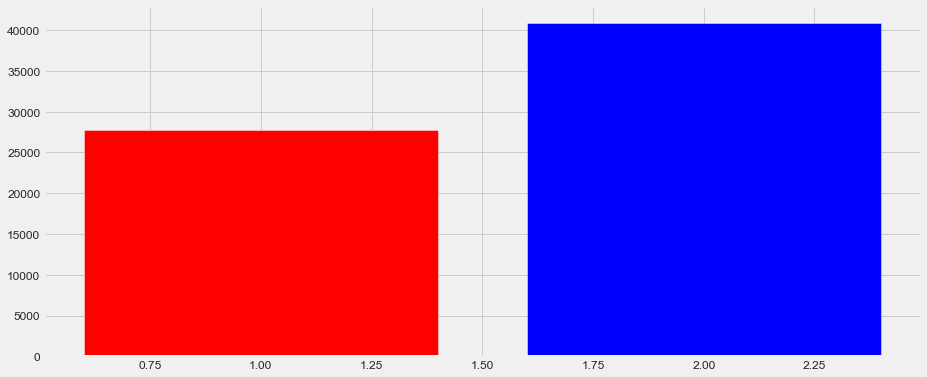

In [139]:
# Plot (vermelho = readmitido e azul = não readimitido)
plt.bar(x = [1,2], height = [paciente_readmitido, paciente_nao_readmitido], color = ['red', 'blue'])

> As classes estão claramente desbalanceadas, ou seja, temos muito mais exemplos de pacientes não readmitidos do que pacientes readmitidos. Vamos resolver isso.

In [140]:
# Carrega o pacote
import imblearn
from imblearn.over_sampling import SMOTE

In [141]:
# Separamos os dados de treino em X e Y (usamos os dados padronizados e depois de criar as variáveis dummy)
X = X_treino_scaled
y = Y_treino

# Extraímos os nomes das colunas das variáveis preditoras
colunas = dados_final.columns

# Criamos o objeto SMOTE
balanceador = SMOTE(random_state = 117)

# Treinamos o balanceador SMOTE
X_treino_scaled_bal, Y_treino_bal = balanceador.fit_resample(X, y)

In [142]:
# Shape antes do balanceamento
X.shape

(54903, 33)

In [143]:
# Shape depois do balanceamento
X_treino_scaled_bal.shape

(65406, 33)

In [144]:
# Shape antes do balanceamento
y.shape

(54903,)

In [145]:
# Shape depois do balanceamento
Y_treino_bal.shape

(65406,)

In [146]:
# Concatenando x e y no mesmo dataframe
dados_pos_balanceamento = pd.DataFrame(X_treino_scaled_bal)
dados_pos_balanceamento['readmitted'] = pd.DataFrame(Y_treino_bal)
dados_pos_balanceamento.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,readmitted
0,-0.939516,-0.784114,1.142497,-0.252290,-0.944052,-0.261553,1.732163,1.315846,-0.183115,-0.228039,...,-0.587958,2.065789,-1.019590,1.019590,-1.267228,1.267228,2.367377,-0.667715,-1.083965,1
1,1.064378,3.278377,1.542975,0.316793,3.647280,-0.261553,-0.204641,1.315846,0.877669,-0.228039,...,1.700801,-0.484076,0.980787,-0.980787,-1.267228,1.267228,-0.422408,-0.667715,0.922539,0
2,1.064378,-0.107032,-0.309237,-0.821373,0.505842,-0.261553,-0.204641,-0.302195,0.877669,-0.228039,...,1.700801,-0.484076,0.980787,-0.980787,0.789124,-0.789124,-0.422408,-0.667715,0.922539,0
3,-0.939516,-1.122655,0.441660,-0.821373,-0.581579,-0.261553,-0.204641,-0.302195,0.347277,-0.228039,...,1.700801,-0.484076,0.980787,-0.980787,0.789124,-0.789124,-0.422408,-0.667715,0.922539,0
4,1.064378,-0.445573,0.041182,0.316793,-0.460754,0.642107,-0.204641,-0.302195,-0.183115,-0.228039,...,1.700801,-0.484076,-1.019590,1.019590,0.789124,-0.789124,-0.422408,1.497645,-1.083965,1


In [147]:
# Shape antes do balanceamento (esse dataframe não tem a coluna target)
dados_final.shape

(68629, 33)

In [148]:
# Shape depois do balanceamento (esse dataframe tem a coluna target)
dados_pos_balanceamento.shape

(65406, 34)

In [149]:
# Separamos as amostras de acordo com o valor da classe, onde 0 representa não readmitido e 1 readmmitido
# Observe que estamos usando como dataset "balanceador_treino"
paciente_nao_readmitido = dados_pos_balanceamento[dados_pos_balanceamento['readmitted']==0].shape[0]
paciente_readmitido = dados_pos_balanceamento[dados_pos_balanceamento['readmitted']==1].shape[0]

<BarContainer object of 2 artists>

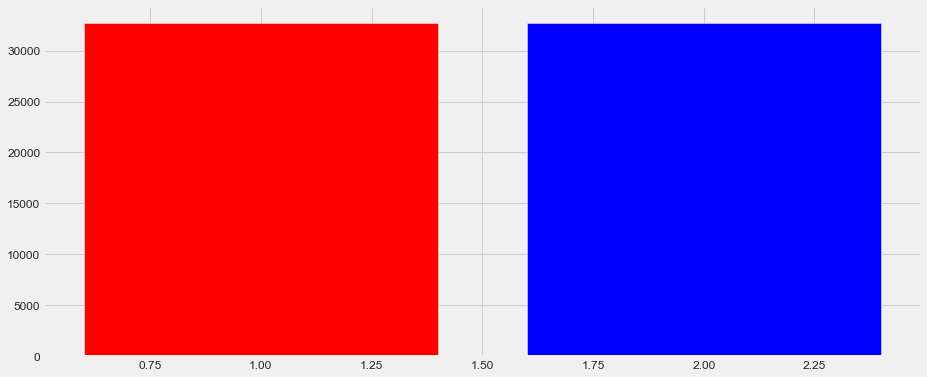

In [150]:
# Plot
plt.bar(x = [1,2], height = [paciente_readmitido, paciente_nao_readmitido], color = ['red', 'blue'])

Com as **classes balanceadas**, vamos refazer o processo e **reconstruir o modelo**.

In [151]:
# Cria o modelo
modelo_lr = LogisticRegression(tol = 1e-7, penalty = 'l2', C = 0.0005, solver = 'liblinear')

# Treina o modelo
modelo_lr.fit(X_treino_scaled_bal, Y_treino_bal)

# Verificando a acurácia do modelo
# https://scikit-learn.org/stable/modules/model_evaluation.html

# Faz as previsões
lr_Y_pred = modelo_lr.predict(X_teste_scaled)

# Calcula o score com dados de teste
lr_accuracy = modelo_lr.score(X_teste_scaled, Y_teste) * 100

# Print
print("\nAcurácia do Modelo de Regressão Logística (%):", lr_accuracy)
print("\n")

# Relatório de Classificação
print(classification_report(Y_teste, lr_Y_pred, target_names = ['Não', 'Sim']))


Acurácia do Modelo de Regressão Logística (%): 58.400116567098934


              precision    recall  f1-score   support

         Não       0.67      0.60      0.63      8176
         Sim       0.49      0.55      0.52      5550

    accuracy                           0.58     13726
   macro avg       0.58      0.58      0.58     13726
weighted avg       0.59      0.58      0.59     13726



**Balanceamento Ponderado das Classes**

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [152]:
from sklearn.utils.class_weight import compute_class_weight

In [153]:
dados.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,comorbidade,num_alt_dosagem_med,num_med
0,Caucasian,0,[0-50),Emergencia,Casa,Sala_Emergencia,3,59,0,18,...,0,9,-99,-99,1,1,1,1,1,1
1,AfricanAmerican,0,[0-50),Emergencia,Casa,Sala_Emergencia,2,11,5,13,...,1,6,-99,-99,0,1,0,1,0,1
2,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,2,44,1,16,...,0,7,-99,-99,1,1,0,3,1,1
3,Caucasian,1,[0-50),Emergencia,Casa,Sala_Emergencia,1,51,0,8,...,0,5,-99,-99,1,1,0,1,0,2
4,Caucasian,1,[50-60),Outro,Casa,Outro,3,31,6,16,...,0,9,-99,-99,0,1,1,3,0,1


In [154]:
# Classes
np.unique(Y_treino_bal)

array([0, 1], dtype=int64)

In [155]:
# Armazena o resultado
classes = np.unique(Y_treino_bal)

In [156]:
# Computando o peso das classes para o dataset não balanceado
compute_class_weight('balanced', classes, Y_treino)

C:\Users\Usuario\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=10955    1
59307    0
61559    0
1922     0
31324    1
        ..
19431    0
9912     0
23493    0
18699    1
27375    0
Name: readmitted, Length: 54903, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([0.8394184 , 1.23655405])

In [157]:
# Computando o peso das classes para o dataset balanceado
compute_class_weight('balanced', classes, Y_treino_bal)

C:\Users\Usuario\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=0        1
1        0
2        0
3        0
4        1
        ..
65401    1
65402    1
65403    1
65404    1
65405    1
Name: readmitted, Length: 65406, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([1., 1.])

In [158]:
# Define o peso para as classes
pesos_classes = {0:0.49, 1:0.51}

In [159]:
# Cria o modelo
modelo_lr = LogisticRegression(tol = 1e-7, 
                               class_weight = pesos_classes, 
                               penalty = 'l2', 
                               C = 0.0005, 
                               solver = 'liblinear')

# Treina o modelo
modelo_lr.fit(X_treino_scaled_bal, Y_treino_bal)

# Verificando a acurácia do modelo
# https://scikit-learn.org/stable/modules/model_evaluation.html

# Faz as previsões
lr_Y_pred = modelo_lr.predict(X_teste_scaled)

# Calcula o score com dados de teste
#Y_teste = Y_teste.map({"Não Readmitido": 0, "Readmitido": 1})
lr_accuracy = modelo_lr.score(X_teste_scaled, Y_teste) * 100

# Print
print("\nAcurácia do Modelo de Regressão Logística (%):", lr_accuracy)
print("\n")

# Relatório de Classificação
print(classification_report(Y_teste, lr_Y_pred, target_names = ['Não', 'Sim']))


Acurácia do Modelo de Regressão Logística (%): 57.47486521929186


              precision    recall  f1-score   support

         Não       0.67      0.56      0.61      8176
         Sim       0.48      0.60      0.53      5550

    accuracy                           0.57     13726
   macro avg       0.58      0.58      0.57     13726
weighted avg       0.59      0.57      0.58     13726



**Variance Inflation Factor**

Em Análise de Regressão Linear (quando queremos prever um valor numérico), podemos checar as variáveis com multicolinearidade (ou, simplesmente, colinearidade). Como podemos detectar colinearidade com os procedimentos de Regressão Logística, quando estamos prevendo uma classe?

Os procedimentos de regressão para variáveis dependentes categóricas não possuem diagnóstico de colinearidade. No entanto, você pode usar o procedimento de regressão linear para esse fim. As estatísticas de colinearidade em regressão dizem respeito às relações entre os preditores, ignorando a variável dependente. Portanto, é possível executar regressão linear com a mesma lista de preditores e variável dependente que você deseja usar em regressão logística (por exemplo) e solicitar o diagnóstico de colinearidade. Execute a regressão logística para obter os coeficientes adequados, probabilidades previstas, etc. e depois calcule o VIF.

Um Fator de Inflação de Variância (Variance Inflation Factor - VIF) detecta multicolinearidade na análise de regressão. Multicolinearidade é quando há correlação entre preditores (ou seja, variáveis independentes) em um modelo; a presença dela pode afetar adversamente os resultados da regressão. O VIF estima quanto a variação de um coeficiente de regressão é inflada devido à multicolinearidade no modelo.

Interpretação do fator de inflação de variação

O VIF varia de 1 para cima. O valor numérico do VIF informa (de maneira decimal) qual a porcentagem em que a variação (isto é, o erro padrão ao quadrado) é inflada para cada coeficiente. Por exemplo, um VIF de 1,9 indica que a variação de um coeficiente específico é 90% maior do que o que você esperaria se não houvesse multicolinearidade - se não houvesse correlação com outros preditores.

Uma regra prática para interpretar o VIF:

- Valor de 1 = não correlacionado.
- Valor entre 1 e 5 = moderadamente correlacionado.
- Valor maior que 5 = altamente correlacionado.

O tamanho exato de um VIF antes de causar problemas é objeto de debate. O que se sabe é que quanto mais o seu VIF aumentar, menos confiáveis serão os resultados da sua regressão. Em geral, um VIF acima de 10 indica alta correlação e é motivo de preocupação. Alguns autores sugerem um nível mais conservador de 2,5 ou superior.

In [160]:
# Converte o array de treino em dataframe
X_treino_df = pd.DataFrame(X_treino_scaled_bal)

In [161]:
# Importância das Variáveis 

# Cria um dataframe que conterá os nomes de todas as variáveis e seus respectivos VIFs
vif = pd.DataFrame()
vif['Atributos'] = dados_final.columns
vif['VIF'] = [variance_inflation_factor(X_treino_df.values, i) for i in range(X_treino_df.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = True)
vif

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Atributos,VIF
0,gender,1.03
5,number_outpatient,1.03
6,number_emergency,1.04
7,number_inpatient,1.05
13,comorbidade,1.09
10,A1Cresult,1.12
8,number_diagnoses,1.22
9,max_glu_serum,1.23
3,num_procedures,1.32
2,num_lab_procedures,1.36


## Modelagem com Random Forest

**Criação do Modelo**

In [162]:
# Define o peso para as classes
pesos_classes = {0:0.47, 1:0.53}

# Cria o modelo
rf = RandomForestClassifier(random_state = 42, 
                            class_weight = pesos_classes, 
                            n_estimators = 100, 
                            min_samples_split = 10)

# Grid de parâmetros
gridparam_rf = {'n_estimators': [100, 200, 500], 'min_samples_split': [5,10,15],}

# Grid Search
modelo_rf = GridSearchCV(rf, cv = 3, param_grid = gridparam_rf)

# Treinamento com Grid Search
modelo_rf.fit(X_treino_scaled_bal, Y_treino_bal)

# Previsões de classe
rf_Y_pred = modelo_rf.predict(X_teste_scaled)

# Previsões de probabilidade
rf_predict_proba = modelo_rf.predict_proba(X_teste_scaled)[:,1] 

**Avaliação do Modelo**

In [163]:
# Verificando a acurácia do modelo

# Calcula o score com dados de teste
rf_accuracy = modelo_rf.score(X_teste_scaled, Y_teste) * 100

# Print
print("Acurácia do Modelo Random Forest (%):", rf_accuracy)

Acurácia do Modelo Random Forest (%): 60.48375346058575


**Matriz de Confusão e Métricas**

In [164]:
# Cria e imprime a matriz de confusão
conf_matriz_rf = confusion_matrix(Y_teste, rf_Y_pred)
print(conf_matriz_rf)

# Calcula o total 
total1 = sum(sum(conf_matriz_rf))

# Calcula a acurácia
accuracy_rf = (conf_matriz_rf[0,0] + conf_matriz_rf[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_rf = conf_matriz_rf[0,0] / (conf_matriz_rf[0,0] + conf_matriz_rf[0,1])
sensi_rf = conf_matriz_rf[1,1] / (conf_matriz_rf[1,0] + conf_matriz_rf[1,1])

# Print
print('\nAcurácia : ', accuracy_rf)
print('Sensibilidade :', sensi_rf)
print('Especificidade :', speci_rf)

[[6122 2054]
 [3370 2180]]

Acurácia :  0.6048375346058575
Sensibilidade : 0.3927927927927928
Especificidade : 0.7487769080234834


**Plot da Matriz de Confusão**

Text(0.5, 1.0, 'Acurácia: 0.6048375346058575')

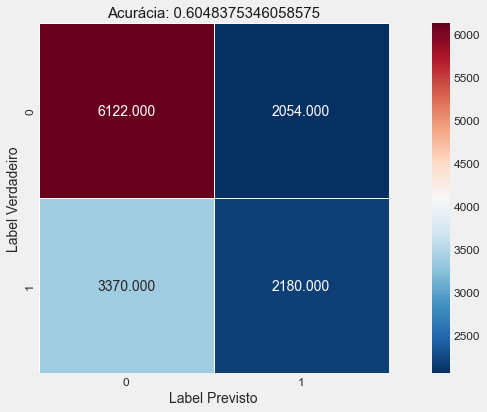

In [165]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(Y_teste, rf_Y_pred), 
            annot = True, 
            fmt = ".3f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
all_sample_title = 'Acurácia: {0}'.format(modelo_rf.score(X_teste_scaled, Y_teste))
plt.title(all_sample_title, size = 15)

**Curva ROC e Score AUC**

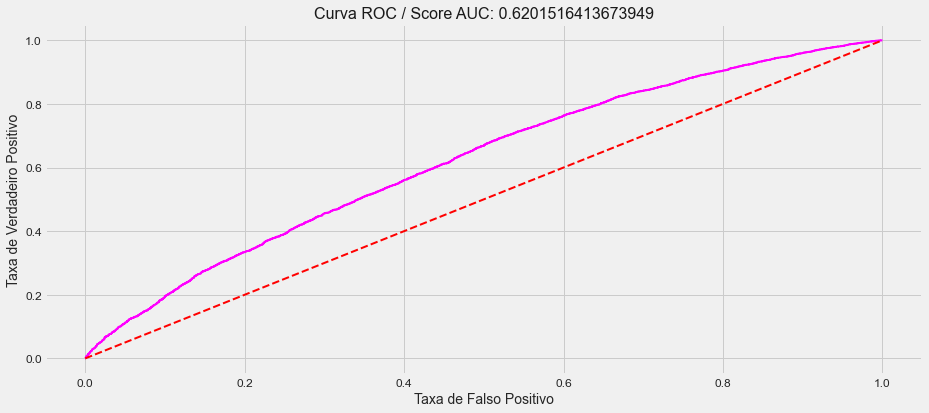

In [166]:
# Extrai as métricas para a Curva ROC
rf_fpr, rf_tpr, thresholds = roc_curve(Y_teste, rf_predict_proba)

# Calcula o AUC
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Cria a figura para o Plot
plt.figure()

# Plot da Curva ROC
plt.plot(rf_fpr, rf_tpr, color = 'magenta', lw = 2, label = 'Curva ROC')

# Cria a linha base (linha tracejada em vermelho)
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')

# Plot de FPR (Taxa de Falso Positivo) e TPR (Taxa de Verdadeiro Positivo)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plot_title = 'Curva ROC / Score AUC: {0}'.format(rf_roc_auc)
plt.title(plot_title , size = 16)
plt.show()

**Relatório de Classificação**

In [167]:
# Relatório de Classificação
print(classification_report(Y_teste, rf_Y_pred, target_names = ['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.64      0.75      0.69      8176
         Sim       0.51      0.39      0.45      5550

    accuracy                           0.60     13726
   macro avg       0.58      0.57      0.57     13726
weighted avg       0.59      0.60      0.59     13726



**Importância das Variáveis**

In [168]:
# Extrai as variáveis mais importantes
importances = modelo_rf.best_estimator_.feature_importances_

In [169]:
# Converte a saída em dataframe
feature_importances = pd.DataFrame(modelo_rf.best_estimator_.feature_importances_,
                                   index = dados_final.columns,
                                   columns = ['importance']).sort_values('importance', ascending = False) 
feature_importances

,importance
num_lab_procedures,0.141205
num_medications,0.127713
time_in_hospital,0.103606
number_diagnoses,0.078861
num_procedures,0.073669
comorbidade,0.061311
num_med,0.036736
number_inpatient,0.034386
number_outpatient,0.031931
gender,0.025991


## Modelagem com Decision Tree

**Criação do Modelo**

In [170]:
# Cria o modelo
dt = DecisionTreeClassifier()

# Grid de parâmetros
gridparam_dt = {'criterion' : ['gini','entropy'], 'max_depth' : [5, 10,15], 'min_samples_split': [5,10,15],}

# Grid Search
modelo_dt = GridSearchCV(dt, cv = 3, param_grid = gridparam_dt)

# Treinamento com Grid Search
modelo_dt.fit(X_treino_scaled_bal, Y_treino_bal)

# Previsões de classe
dt_Y_pred = modelo_dt.predict(X_teste_scaled)

# Previsões de probabilidade
dt_predict_proba = modelo_dt.predict_proba(X_teste_scaled)[:,1] 

**Avaliação do Modelo**

In [171]:
# Verificando a acurácia do modelo

# Calcula o score com dados de teste
dt_accuracy = modelo_dt.score(X_teste_scaled, Y_teste) * 100

# Print
print("Acurácia do Modelo de Árvore de Decisão (%):", dt_accuracy)

Acurácia do Modelo de Árvore de Decisão (%): 55.850211277866826


In [172]:
# Melhores hiperparâmetros
print('Melhor Acurácia em Treino: ', modelo_dt.best_score_)
print('Melhores Hiperparâmetros: ', modelo_dt.best_params_)

Melhor Acurácia em Treino:  0.5704828303213773
Melhores Hiperparâmetros:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


**Matriz de Confusão e Métricas**

In [173]:
# Cria e imprime a matriz de confusão
conf_matriz_dt = confusion_matrix(Y_teste, dt_Y_pred)
print(conf_matriz_dt)

# Calcula o total 
total1 = sum(sum(conf_matriz_dt))

# Calcula a acurácia
accuracy_dt = (conf_matriz_dt[0,0] + conf_matriz_dt[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_dt = conf_matriz_dt[0,0] / (conf_matriz_dt[0,0] + conf_matriz_dt[0,1])
sensi_dt = conf_matriz_dt[1,1] / (conf_matriz_dt[1,0] + conf_matriz_dt[1,1])

# Print
print('\nAcurácia : ', accuracy_dt)
print('Sensibilidade :', sensi_dt)
print('Especificidade :', speci_dt)

[[4469 3707]
 [2353 3197]]

Acurácia :  0.5585021127786682
Sensibilidade : 0.576036036036036
Especificidade : 0.5465998043052838


**Plot da Matriz de Confusão**

Text(0.5, 1.0, 'Acurácia: 0.5585021127786682')

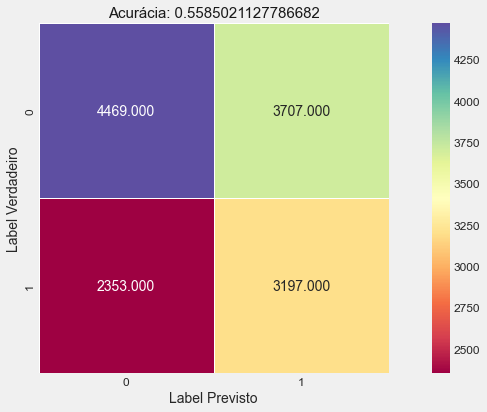

In [174]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(Y_teste, dt_Y_pred), 
            annot = True, 
            fmt = ".3f", 
            linewidths = .5, 
            square = True, 
            cmap = 'Spectral')

# Labels e Títulos
plt.ylabel('Label Verdadeiro');
plt.xlabel('Label Previsto');
all_sample_title = 'Acurácia: {0}'.format(modelo_dt.score(X_teste_scaled, Y_teste))
plt.title(all_sample_title, size = 15)

**Curva ROC e Score AU**

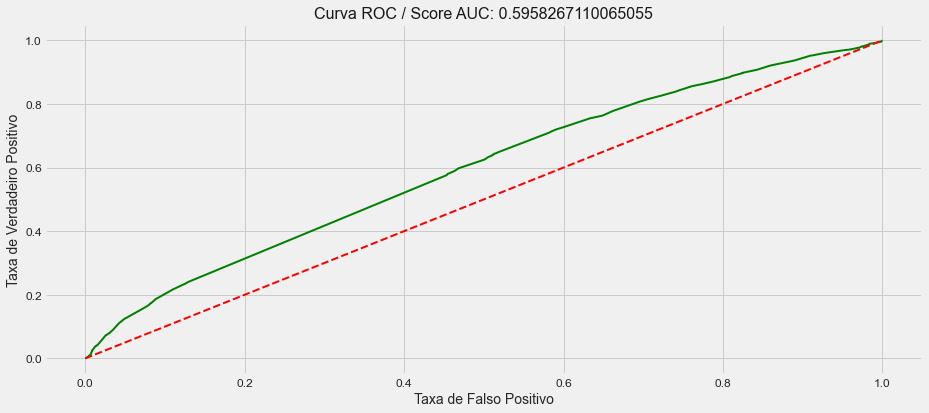

In [175]:
# Extrai as métricas para a Curva ROC
dt_fpr, dt_tpr, thresholds = roc_curve(Y_teste, dt_predict_proba)

# Calcula o AUC
dt_roc_auc = auc(dt_fpr, dt_tpr)

# Cria a figura para o Plot
plt.figure()

# Plot da Curva ROC
plt.plot(dt_fpr, dt_tpr, color = 'green', lw = 2, label = 'Curva ROC')

# Cria a linha base (linha tracejada em vermelho)
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')

# Plot de FPR (Taxa de Falso Positivo) e TPR (Taxa de Verdadeiro Positivo)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plot_title = 'Curva ROC / Score AUC: {0}'.format(dt_roc_auc)
plt.title(plot_title , size = 16)
plt.show()

**Relatório de Classificação**

In [176]:
# Relatório de Classificação
print(classification_report(Y_teste, dt_Y_pred, target_names = ['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.66      0.55      0.60      8176
         Sim       0.46      0.58      0.51      5550

    accuracy                           0.56     13726
   macro avg       0.56      0.56      0.55     13726
weighted avg       0.58      0.56      0.56     13726



**Importância das Variáveis**

In [177]:
# Extrai as variáveis mais importantes
importances = modelo_dt.best_estimator_.feature_importances_

In [178]:
# Converte a saída em dataframe
feature_importances = pd.DataFrame(modelo_dt.best_estimator_.feature_importances_,
                                   index = dados_final.columns,
                                   columns = ['importance']).sort_values('importance', ascending = False) 
feature_importances

,importance
number_diagnoses,0.254496
number_inpatient,0.225060
number_outpatient,0.135652
comorbidade,0.115778
time_in_hospital,0.095980
num_lab_procedures,0.029574
num_procedures,0.027632
num_medications,0.021809
number_emergency,0.020041
admission_source_id_Sala_Emergencia,0.007733


## Modelagem com AdaBoost

**Criação do Modelo**

In [179]:
# Cria o modelo
ab = AdaBoostClassifier(random_state = 123)

# Grid de parâmetros
gridparam_ab = {'n_estimators': [100,200,500], 'learning_rate': [0.2,0.5,1.0],}

# Grid Search
modelo_ab = GridSearchCV(ab, cv = 3, param_grid = gridparam_ab)

# Treinamento com Grid Search
modelo_ab.fit(X_treino_scaled_bal, Y_treino_bal)

# Previsões de classe
ab_Y_pred = modelo_ab.predict(X_teste_scaled)

# Previsões de probabilidade
ab_predict_proba = modelo_ab.predict_proba(X_teste_scaled)[:,1] 

**Avaliação do Modelo**

In [180]:
# Verificando a acurácia do modelo

# Calcula o score com dados de teste
ab_accuracy = modelo_ab.score(X_teste_scaled, Y_teste) * 100

# Print
print("Acurácia do Modelo Adaboost (%):", ab_accuracy)

Acurácia do Modelo Adaboost (%): 59.52207489436107


In [181]:
# Melhores hiperparâmetros
print('Melhor Acurácia em Treino: ', modelo_ab.best_score_)
print('Melhores Hiperparâmetros: ', modelo_ab.best_params_)

Melhor Acurácia em Treino:  0.5842736140415252
Melhores Hiperparâmetros:  {'learning_rate': 0.2, 'n_estimators': 100}


**Matriz de Confusão e Métricas**

In [183]:
# Cria e imprime a matriz de confusão
conf_matriz_ab = confusion_matrix(Y_teste, ab_Y_pred)
print(conf_matriz_ab)

# Calcula o total 
total1 = sum(sum(conf_matriz_ab))

# Calcula a acurácia
accuracy_ab = (conf_matriz_ab[0,0] + conf_matriz_ab[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_ab = conf_matriz_ab[0,0] / (conf_matriz_ab[0,0] + conf_matriz_ab[0,1])
sensi_ab = conf_matriz_ab[1,1] / (conf_matriz_ab[1,0] + conf_matriz_ab[1,1])

# Print
print('\nAcurácia : ', accuracy_ab)
print('Sensibilidade :', sensi_ab)
print('Especificidade :', speci_ab)

[[5382 2794]
 [2762 2788]]

Acurácia :  0.5952207489436107
Sensibilidade : 0.5023423423423423
Especificidade : 0.6582681017612525


**Plot da Matriz de Confusão**

Text(0.5, 1.0, 'Acurácia: 0.5952207489436107')

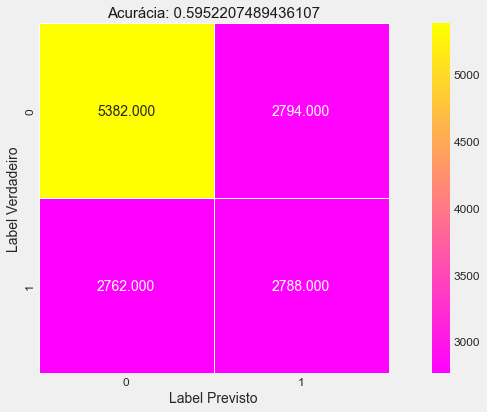

In [184]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(Y_teste, ab_Y_pred), 
            annot = True, 
            fmt = ".3f", 
            linewidths = .5, 
            square = True, 
            cmap = 'spring')

# Labels e Títulos
plt.ylabel('Label Verdadeiro');
plt.xlabel('Label Previsto');
all_sample_title = 'Acurácia: {0}'.format(modelo_ab.score(X_teste_scaled, Y_teste))
plt.title(all_sample_title, size = 15)

**Curva ROC e Score AUC**

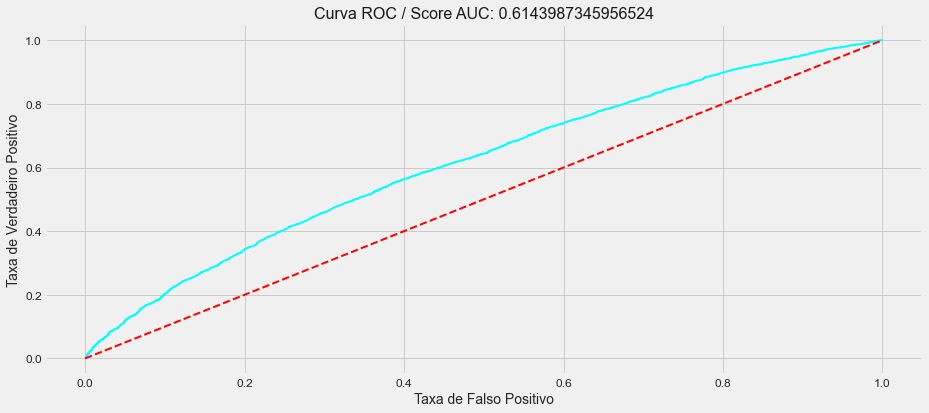

In [185]:
# Extrai as métricas para a Curva ROC
ab_fpr, ab_tpr, thresholds = roc_curve(Y_teste, ab_predict_proba)

# Calcula o AUC
ab_roc_auc = auc(ab_fpr, ab_tpr)

# Cria a figura para o Plot
plt.figure()

# Plot da Curva ROC
plt.plot(ab_fpr, ab_tpr, color = 'cyan', lw = 2, label = 'Curva ROC')

# Cria a linha base (linha tracejada em vermelho)
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')

# Plot de FPR (Taxa de Falso Positivo) e TPR (Taxa de Verdadeiro Positivo)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plot_title = 'Curva ROC / Score AUC: {0}'.format(ab_roc_auc)
plt.title(plot_title , size = 16)
plt.show()

**Relatório de Classificação**

In [186]:
# Relatório de Classificação
print(classification_report(Y_teste, dt_Y_pred, target_names = ['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.66      0.55      0.60      8176
         Sim       0.46      0.58      0.51      5550

    accuracy                           0.56     13726
   macro avg       0.56      0.56      0.55     13726
weighted avg       0.58      0.56      0.56     13726



**Importância das Variáveis**

In [187]:
# Extrai as variáveis mais importantes
importances = modelo_ab.best_estimator_.feature_importances_

In [188]:
# Converte a saída em dataframe
feature_importances = pd.DataFrame(modelo_ab.best_estimator_.feature_importances_,
                                   index = dados_final.columns,
                                   columns = ['importance']).sort_values('importance', ascending = False) 
feature_importances

,importance
num_procedures,0.34
comorbidade,0.25
number_inpatient,0.08
time_in_hospital,0.06
number_diagnoses,0.06
number_outpatient,0.05
num_medications,0.04
number_emergency,0.03
admission_source_id_Outro,0.02
diabetesMed,0.02


## Modelagem com Deep Learning

**Criação do Modelo**

In [189]:
# Cria o modelo
modelo_dl = Sequential()

In [190]:
# Adiciona as camadas ocultas
modelo_dl.add(Dense(units = 26, kernel_initializer = 'uniform', activation = 'relu', input_dim = 33))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [191]:
# Compila o modelo
modelo_dl.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [192]:
# Define o peso para as classes
pesos_classes = {0:0.49, 1:0.51}

In [193]:
# Treinamento do modelo
modelo_dl.fit(X_treino_scaled_bal, Y_treino_bal, batch_size = 10, epochs = 100, class_weight = pesos_classes)

Epoch 1/100
6541/6541 [==============================] - 21s 3ms/step - loss: 0.3347 - accuracy: 0.5841
Epoch 2/100
6541/6541 [==============================] - 20s 3ms/step - loss: 0.3315 - accuracy: 0.5975
Epoch 3/100
6541/6541 [==============================] - 20s 3ms/step - loss: 0.3297 - accuracy: 0.6026
Epoch 4/100
6541/6541 [==============================] - 19s 3ms/step - loss: 0.3288 - accuracy: 0.6072
Epoch 5/100
6541/6541 [==============================] - 19s 3ms/step - loss: 0.3278 - accuracy: 0.6078
Epoch 6/100
6541/6541 [==============================] - 19s 3ms/step - loss: 0.3272 - accuracy: 0.6085
Epoch 7/100
6541/6541 [==============================] - 20s 3ms/step - loss: 0.3262 - accuracy: 0.6138
Epoch 8/100
6541/6541 [==============================] - 21s 3ms/step - loss: 0.3257 - accuracy: 0.6147
Epoch 9/100
6541/6541 [==============================] - 19s 3ms/step - loss: 0.3251 - accuracy: 0.6177
Epoch 10/100
6541/6541 [==============================] - 21s 3m

6541/6541 [==============================] - 21s 3ms/step - loss: 0.2934 - accuracy: 0.6746
Epoch 78/100
6541/6541 [==============================] - 30s 5ms/step - loss: 0.2931 - accuracy: 0.6758
Epoch 79/100
6541/6541 [==============================] - 30s 5ms/step - loss: 0.2928 - accuracy: 0.6765
Epoch 80/100
6541/6541 [==============================] - 29s 4ms/step - loss: 0.2926 - accuracy: 0.6753 0s -
Epoch 81/100
6541/6541 [==============================] - 35s 5ms/step - loss: 0.2917 - accuracy: 0.6783
Epoch 82/100
6541/6541 [==============================] - 24s 4ms/step - loss: 0.2918 - accuracy: 0.6779
Epoch 83/100
6541/6541 [==============================] - 22s 3ms/step - loss: 0.2918 - accuracy: 0.6785
Epoch 84/100
6541/6541 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.67 - 21s 3ms/step - loss: 0.2918 - accuracy: 0.6786
Epoch 85/100
6541/6541 [==============================] - 26s 4ms/step - loss: 0.2908 - accuracy: 0.6789
Epoch 86/100
6541/654

**Avaliação do Modelo**

In [194]:
# Realiza as previsões
dl_Y_pred = modelo_dl.predict(X_teste_scaled)

In [195]:
# As previsões são probabilidades
dl_Y_pred

array([[0.12912768],
       [0.16392934],
       [0.4612828 ],
       ...,
       [0.38085625],
       [0.37410673],
       [0.6635151 ]], dtype=float32)

In [196]:
# Converte as probabilidades em classe
dl_t_Y_pred = (dl_Y_pred > 0.5)

In [197]:
# Agora as previsões são classes, em valores booleanos
dl_t_Y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [198]:
# Agora convertemos os valores booleanos em classe binária, 0 ou 1
Y_dl_pred = np.where(dl_t_Y_pred == 'True', 1, dl_t_Y_pred)
Y_dl_pred

C:\Users\Usuario\AppData\Local\Temp/ipykernel_12248/3941111679.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  Y_dl_pred = np.where(dl_t_Y_pred == 'True', 1, dl_t_Y_pred)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

**Plot da Matriz de Confusão**

In [199]:
# Cria e imprime a matriz de confusão
conf_matriz_dl = confusion_matrix(Y_teste, Y_dl_pred)
print(conf_matriz_dl)

# Calcula o total 
total1 = sum(sum(conf_matriz_dl))

# Calcula a acurácia
accuracy_dl = (conf_matriz_dl[0,0] + conf_matriz_dl[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_dl = conf_matriz_dl[0,0] / (conf_matriz_dl[0,0] + conf_matriz_dl[0,1])
sensi_dl = conf_matriz_dl[1,1] / (conf_matriz_dl[1,0] + conf_matriz_dl[1,1])

# Print
print('\nAcurácia : ', accuracy_dl)
print('Sensibilidade :', sensi_dl)
print('Especificidade :', speci_dl)

[[4849 3327]
 [2540 3010]]

Acurácia :  0.5725630190878624
Sensibilidade : 0.5423423423423424
Especificidade : 0.5930772994129159


Text(0.5, 1.0, 'Acurácia: 0.5725630190878624')

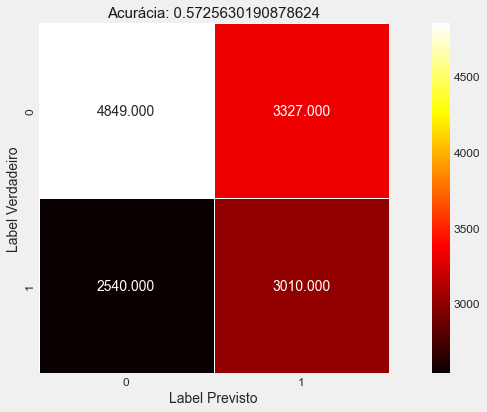

In [200]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(Y_teste, Y_dl_pred), 
            annot = True, 
            fmt = ".3f", 
            linewidths = .5, 
            square = True, 
            cmap = 'hot')

# Labels e Títulos
plt.ylabel('Label Verdadeiro');
plt.xlabel('Label Previsto');
all_sample_title = 'Acurácia: {0}'.format(accuracy_dl)
plt.title(all_sample_title, size = 15)

**Curva ROC e Score AUC**

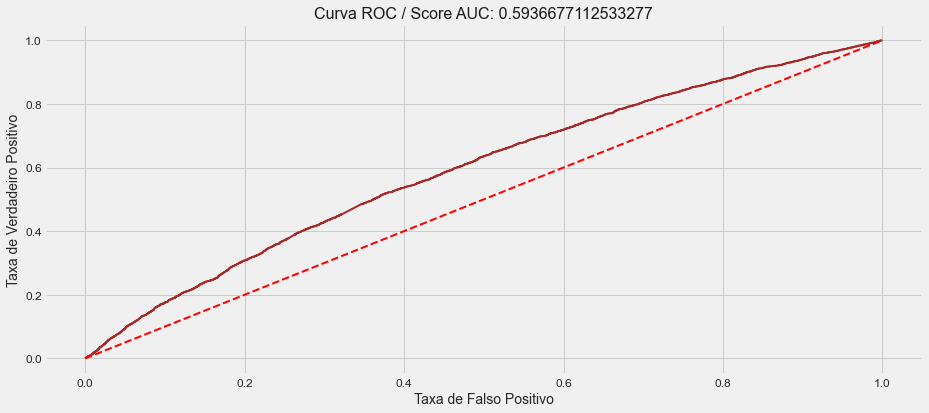

In [201]:
# Extrai as métricas para a Curva ROC (aqui usamos as previsões das probabilidades)
dl_fpr, dl_tpr, thresholds = roc_curve(Y_teste, dl_Y_pred)

# Calcula o AUC
dl_roc_auc = auc(dl_fpr, dl_tpr)

# Cria a figura para o Plot
plt.figure()

# Plot da Curva ROC
plt.plot(dl_fpr, dl_tpr, color = 'brown', lw = 2, label = 'Curva ROC')

# Cria a linha base (linha tracejada em vermelho)
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')

# Plot de FPR (Taxa de Falso Positivo) e TPR (Taxa de Verdadeiro Positivo)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plot_title = 'Curva ROC / Score AUC: {0}'.format(dl_roc_auc)
plt.title(plot_title , size = 16)
plt.show()

**Relatório de Classificação**

In [202]:
# Relatório de Classificação
print(classification_report(Y_teste, Y_dl_pred, target_names = ['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.66      0.59      0.62      8176
         Sim       0.47      0.54      0.51      5550

    accuracy                           0.57     13726
   macro avg       0.57      0.57      0.56     13726
weighted avg       0.58      0.57      0.58     13726



**Importância das Variáveis**

> Os modelos de Deep Learning são considerados "Black Box" pois é muito difícil extrair informações sobre as variáveis. No curso de Machine Learning Para Medicina estudaremos técnicas de interpretação que se aplicam a esses modelos.

# 4.0 Comparação Entre os Modelos

Text(0, 0.5, 'Taxa de Verdadeiro Positivo')

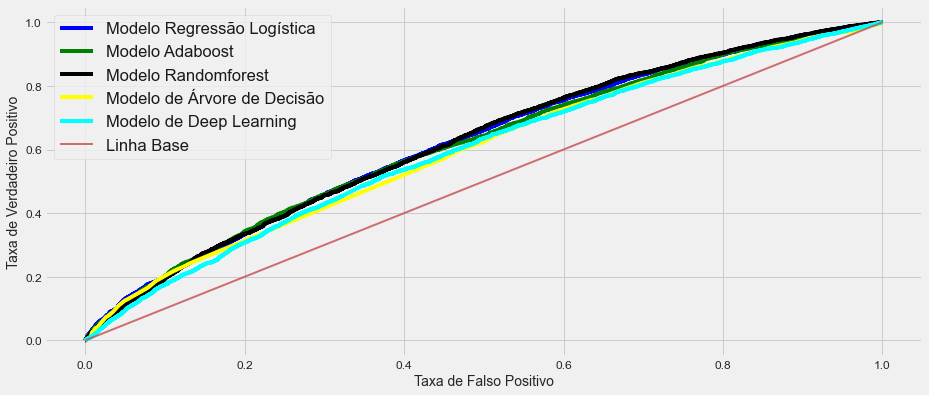

In [203]:
# Comparação via Curva ROC
plt.plot(lr_fpr, lr_tpr, label = 'Modelo Regressão Logística',color = 'blue')
plt.plot(ab_fpr, ab_tpr, label = 'Modelo Adaboost', color = 'green')
plt.plot(rf_fpr, rf_tpr, label = 'Modelo Randomforest',color = 'black')
plt.plot(dt_fpr, dt_tpr, label = 'Modelo de Árvore de Decisão', color = 'yellow')
plt.plot(dl_fpr, dl_tpr, label = 'Modelo de Deep Learning', color = 'cyan')

# Cria a linha base (linha tracejada em vermelho)
plt.plot([0, 1], [0, 1], linestyle = '-', lw = 2, color = 'r', label = 'Linha Base', alpha = .8)

# Plot
plt.legend()
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')

**Vamos resumir a performance em um dataframe**

In [204]:
# Prepara a lista de resultados
metricas = [(accuracy_lr, lr_roc_auc),
            (accuracy_rf, rf_roc_auc),
            (accuracy_dt, dt_roc_auc),
            (accuracy_ab, ab_roc_auc),   
            (accuracy_dl, dl_roc_auc)]

In [205]:
# Cria o dataframe
df_metricas = pd.DataFrame(metricas, columns = ['Accuracy' , 'AUC'], 
                           index = ['LogisticRegression', 'RandomForest', 'DecisionTree', 'AdaBoost', 'DeepLearning']) 

In [206]:
# Visualiza o resultado
df_metricas

,Accuracy,AUC
LogisticRegression,0.616276,0.620049
RandomForest,0.604838,0.620152
DecisionTree,0.558502,0.595827
AdaBoost,0.595221,0.614399
DeepLearning,0.572563,0.593668


> Considerando as duas métricas, o modelo de **Regressão Logística** apresentou o melhor resultado.

# 5.0 Estratificação de Risco

Usaremos o modelo que apresentou as melhores métricas globais, Acurácia e Score AUC.

In [207]:
# Probabilidades Previstas (em dados de teste)
lr_predict_proba = modelo_lr.predict_proba(X_teste_scaled)[:,1] 
lr_predict_proba

array([0.35861439, 0.50853642, 0.55617956, ..., 0.52024309, 0.51654903,
       0.48369472])

In [208]:
# Dataframe com as probabilidades previstas (em dados de teste)
df_proba = pd.DataFrame(lr_predict_proba, columns = ['Probabilidade'])

In [209]:
# Visualiza os dados
df_proba

,Probabilidade
0,0.358614
1,0.508536
2,0.556180
3,0.527606
4,0.445397
...,...
13721,0.448014
13722,0.447596
13723,0.520243
13724,0.516549


In [210]:
# Função para estratificar o risco
def classifica_risco(row):
    if row[0] <= 0.3 : return 'Baixo'
    if row[0] >= 0.7 : return 'Alto'
    return 'Medio'

In [211]:
# Dataframe para o risco estratificado
df_risco = pd.DataFrame()

In [212]:
# Agora carregamos o dataframe
df_risco['Risco'] = df_proba.apply(classifica_risco, axis = 1)

In [213]:
# Total de registros por risco
df_risco['Risco'].value_counts()

Medio    13359
Alto       326
Baixo       41
Name: Risco, dtype: int64

In [214]:
# Vamos separar em percentual
percentual = round(df_risco.Risco.value_counts() / len(df_risco.index) * 100, 1)

In [215]:
# Legenda para o gráfico
sub = ['Medio', 'Alto', 'Baixo']

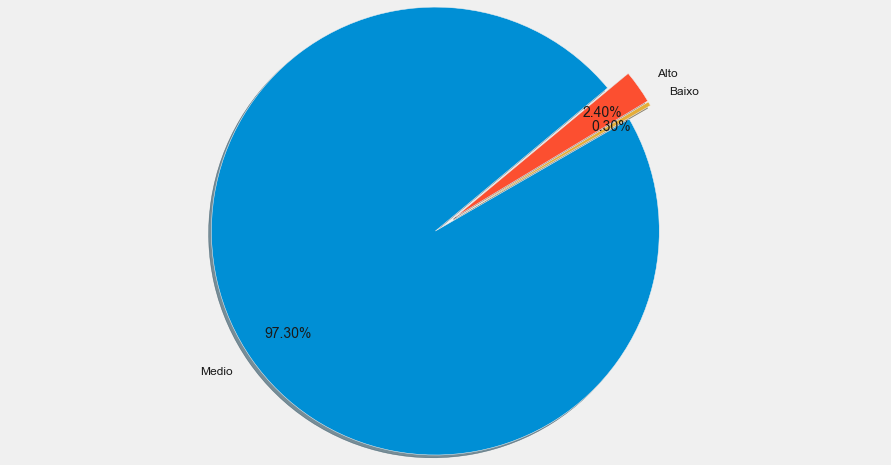

In [216]:
# Plot
plt.axis("equal")
plt.pie(percentual , 
        labels = sub, 
        radius = 1.6,
        autopct = '%1.2f%%',
        explode = [0.09,0.09,0.09],
        startangle = 30,
        shadow = True,
        counterclock = False,
        pctdistance = 0.8)

plt.show()

Mais um Plot para confirmar o resultado

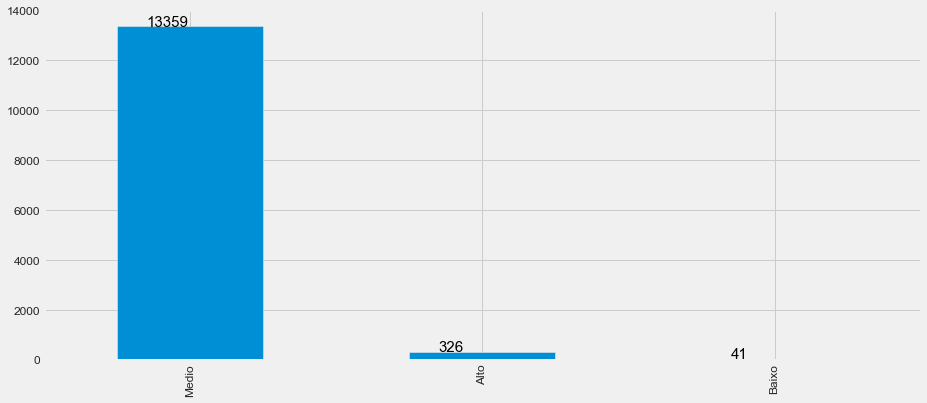

In [217]:
# Conta os valores
figx = df_risco['Risco'].value_counts().plot.bar()

# Plot do texto com os totais
for i in figx.patches:
    figx.text(i.get_x()+.1, 
              i.get_height()+0.2, 
              str(round((i.get_height()), 2)), 
              fontsize = 15, 
              color = 'black',
              rotation = 0)
    
plt.show()

# 6.0 Previção do Risco de Readmissão com Novos Dados

As mesmas transformações que foram aplicadas em dados de teste e treino devem ser aplicadas aos novos dados. Isso pode ser feito no momento das previsões ou previamente no momento da coletas dos dados.

Neste exemplo, os dados já estão no formato usado no treinamento, com exceção da padronização, que aplicaremos agora.

In [218]:
# O pacote pickle converte o modelo para ser salvo em disco
import pickle

In [219]:
# Salvamos o melhor modelo em disco
with open('modelos/modelo_lr.pck', 'wb') as f:
    pickle.dump(modelo_lr, f)

In [220]:
# Carregando novos dados (diferentes dos dados de treino e teste)
novos_dados = pd.read_csv("dados/novos_dados_pacientes.csv")

In [221]:
# Visualiza os dados
novos_dados.head()

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,age_[60-70),age_[70-80),age_[80-100),admission_type_id_Emergencia,admission_type_id_Outro,discharge_disposition_id_Casa,discharge_disposition_id_Outro,admission_source_id_Outro,admission_source_id_Recomendacao,admission_source_id_Sala_Emergencia
0,0,3,60,0,19,0,0,0,9,-99,...,0,0,0,1,0,1,0,0,0,1
1,1,2,13,5,15,2,0,1,6,-99,...,0,0,0,1,0,1,0,0,0,1
2,0,2,41,1,17,0,0,0,7,-99,...,0,0,0,1,0,1,0,0,0,1
3,1,1,52,0,8,0,0,0,5,-99,...,0,0,0,1,0,1,0,0,0,1
4,0,6,39,6,16,0,0,0,9,-99,...,0,0,0,0,1,1,0,1,0,0


In [222]:
# Shape
novos_dados.shape

(5, 33)

In [223]:
# Padronizamos os dados aplicando apenas o transform()
novos_dados_scaled = scaler.transform(novos_dados)

In [224]:
# Carregamos o modelo treinado                                                                                                  
with open('modelos/modelo_lr.pck', 'rb') as f:
    lr_modelo = pickle.load(f)

In [225]:
# Fazemos previsões com o modelo, extraindo as probabilidades
# Previsões de probabilidade
previsoes = lr_modelo.predict_proba(novos_dados_scaled)[:,1] 

In [226]:
# Dataframe com as probabilidades previstas 
df_proba_novos_dados = pd.DataFrame(previsoes, columns = ['Probabilidade'])

In [227]:
# Dataframe para o risco estratificado
df_risco_novos_dados = pd.DataFrame()

In [228]:
# Agora carregamos o dataframe
df_risco_novos_dados['Risco'] = df_proba_novos_dados.apply(classifica_risco, axis = 1)

In [229]:
# Risco de Readmissão Previsto Para os Novos Pacientes
df_risco_novos_dados

,Risco
0,Medio
1,Medio
2,Medio
3,Medio
4,Medio


**Observações e Próximos Passos:**

Nossos modelos não alcançaram uma performance excelente e ainda há espaço para melhoria. Para o proximo ciclo:

1- Trabalhar um pouco mais na otimização dos hiperparâmetros.

2- Experimentar outros modelos, como Naive Bayes e SVM.

3- Pode ser interessante fazer mais alguns experimentos com as variáveis e talvez mudar alguns dos critérios que adotamos na primeira parte.

4- Experimentar outro modelo com diferentes valores para sensibilidade e especificidade e avalie e compare a estratificação de risco.

# Fim